Data can be found here: https://www.kaggle.com/datasets/uciml/faulty-steel-plates

# EDA

## Statistics

In [1]:
# import packages
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import umap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, CategoricalFocalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotNormal
from scipy.special import softmax
from pytorch_tabnet.tab_model import TabNetClassifier
import warnings
warnings.filterwarnings('ignore')

2025-02-12 14:35:59.782836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 14:35:59.875165: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 14:35:59.876737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 14:36:01.359611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


load and display the dataset

In [2]:
df = pd.read_csv('csv/faults.csv')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


General infos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} features, while having {df.isnull().sum().sum()} null values.')
print(f'Features have data type {df.dtypes.unique()[0]} and {df.dtypes.unique()[1]}.')

The dataset has 1941 rows and 34 features, while having 0 null values.
Features have data type int64 and float64.


Statistics about the features

In [5]:
#df_OHE = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]
df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,1941.0,5.711360e+02,5.206907e+02,0.0000,51.0000,4.350000e+02,1.053000e+03,1.705000e+03
X_Maximum,1941.0,6.179645e+02,4.976274e+02,4.0000,192.0000,4.670000e+02,1.072000e+03,1.713000e+03
Y_Minimum,1941.0,1.650685e+06,1.774578e+06,6712.0000,471253.0000,1.204128e+06,2.183073e+06,1.298766e+07
Y_Maximum,1941.0,1.650739e+06,1.774590e+06,6724.0000,471281.0000,1.204136e+06,2.183084e+06,1.298769e+07
Pixels_Areas,1941.0,1.893878e+03,5.168460e+03,2.0000,84.0000,1.740000e+02,8.220000e+02,1.526550e+05
X_Perimeter,1941.0,1.118552e+02,3.012092e+02,2.0000,15.0000,2.600000e+01,8.400000e+01,1.044900e+04
Y_Perimeter,1941.0,8.296600e+01,4.264829e+02,1.0000,13.0000,2.500000e+01,8.300000e+01,1.815200e+04
Sum_of_Luminosity,1941.0,2.063121e+05,5.122936e+05,250.0000,9522.0000,1.920200e+04,8.301100e+04,1.159141e+07
Minimum_of_Luminosity,1941.0,8.454869e+01,3.213428e+01,0.0000,63.0000,9.000000e+01,1.060000e+02,2.030000e+02
Maximum_of_Luminosity,1941.0,1.301937e+02,1.869099e+01,37.0000,124.0000,1.270000e+02,1.400000e+02,2.530000e+02


Lower the name of the columns

In [6]:
df.columns = map(str.lower, df.columns)

Create a column encoding the anomalies features


In [7]:
# list of the anomalies features present in the dataset
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults'] 
# list of the features of the steel plates
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas'] 
# mapper for the encoding
enc_dict = {'pastry' : 0, 
            'z_scratch' : 1,
            'k_scatch' : 2, 
            'stains' : 3,
            'dirtiness' : 4, 
            'bumps' : 5, 
            'other_faults' : 6} 

df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)

# remove troublesome outlier
df.drop(391, inplace = True) 

In [8]:
X = df[feat_col]
y = df['anomaly']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
clf = RandomForestClassifier(n_estimators = 100, random_state = 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7757731958762887

In [10]:
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feat_col, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 

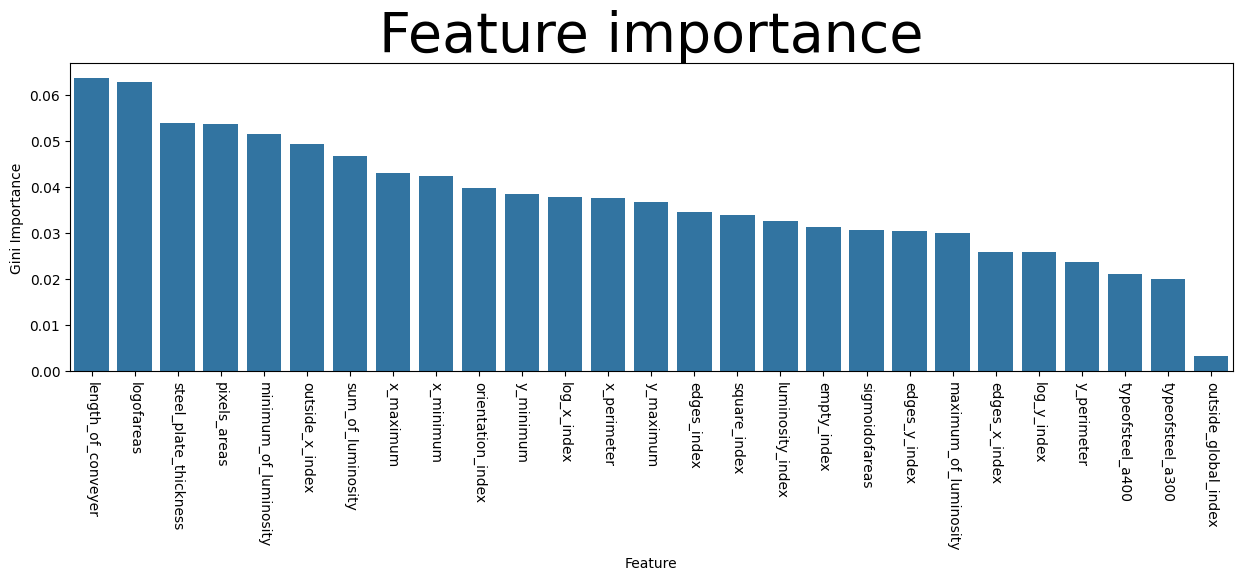

In [11]:
plt.figure(figsize = (15, 4))
plt.title('Feature importance', fontsize = 40)
sns.barplot(feature_imp_df, x = 'Feature', y = 'Gini Importance')
plt.xticks(fontsize = 10, rotation = 270)
plt.show()

## Histograms of the features

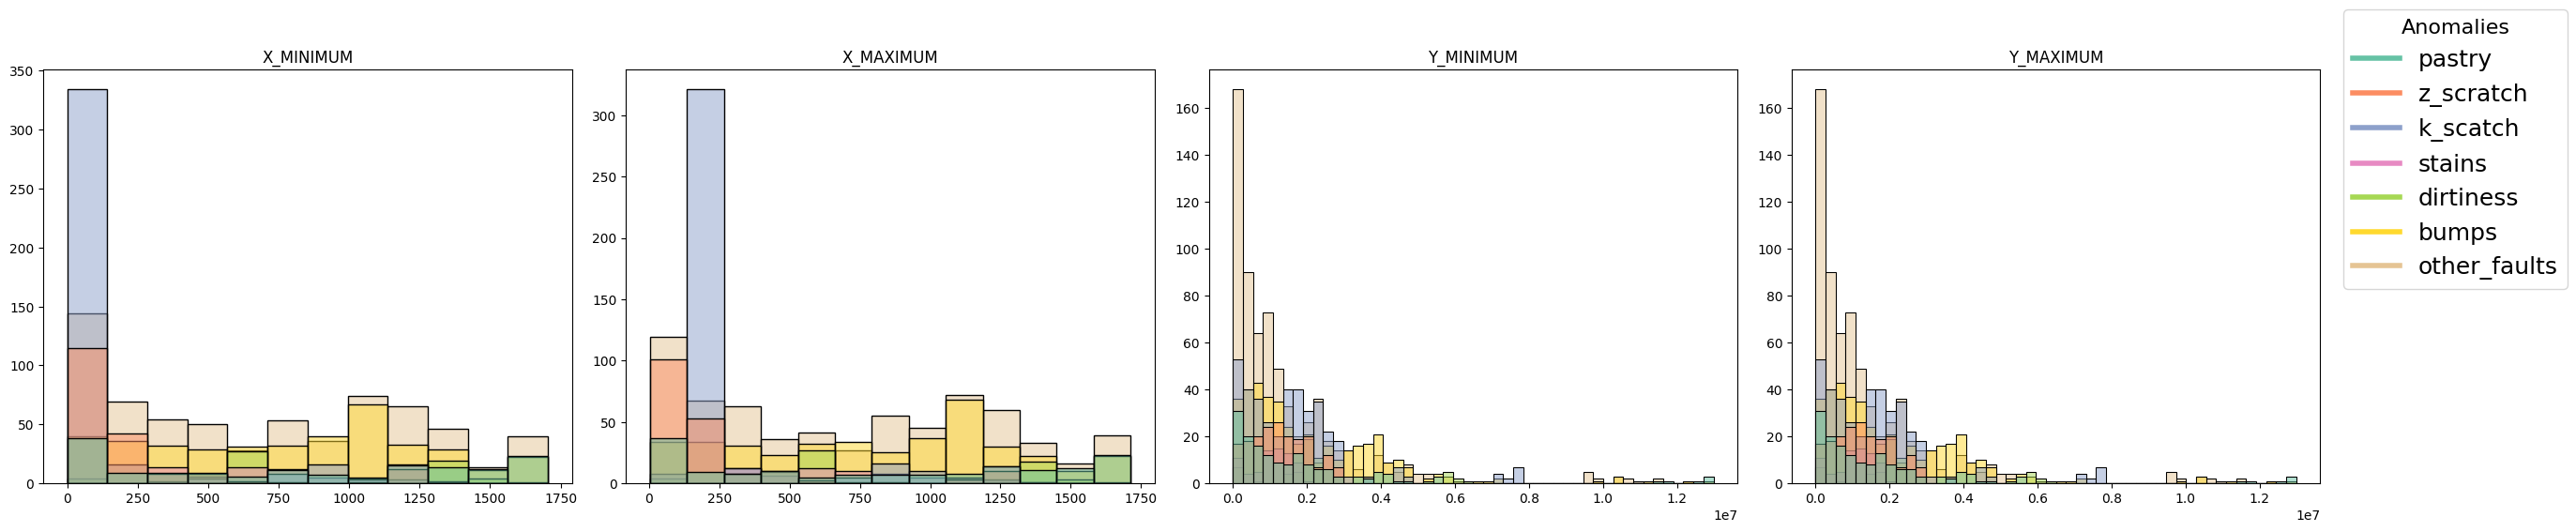

In [12]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

palette_hist = sns.color_palette('Set2', n_colors = len(df['anomaly'].unique()))
hue_order = df['anomaly'].unique()

colors = sns.color_palette('Set2', len(target_cols))
handles = [plt.Line2D([0], [0], color = colors[i], lw = 4, label = str(target_cols[i])) for i in range(len(target_cols))]

for index, col in enumerate(feat_col[:4]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

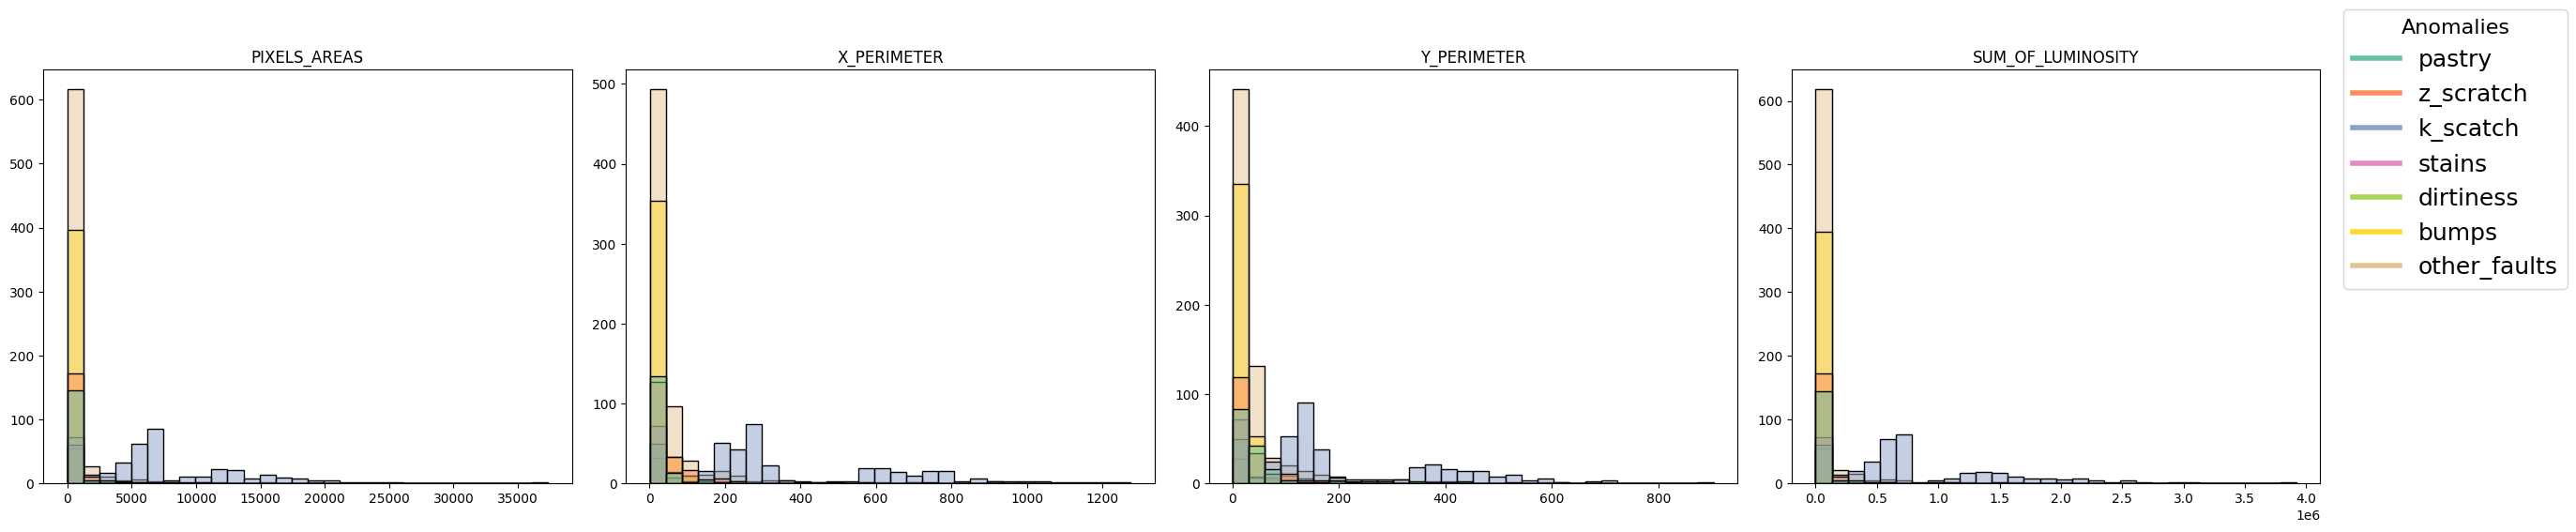

In [13]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False, bins = 30)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('') 

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

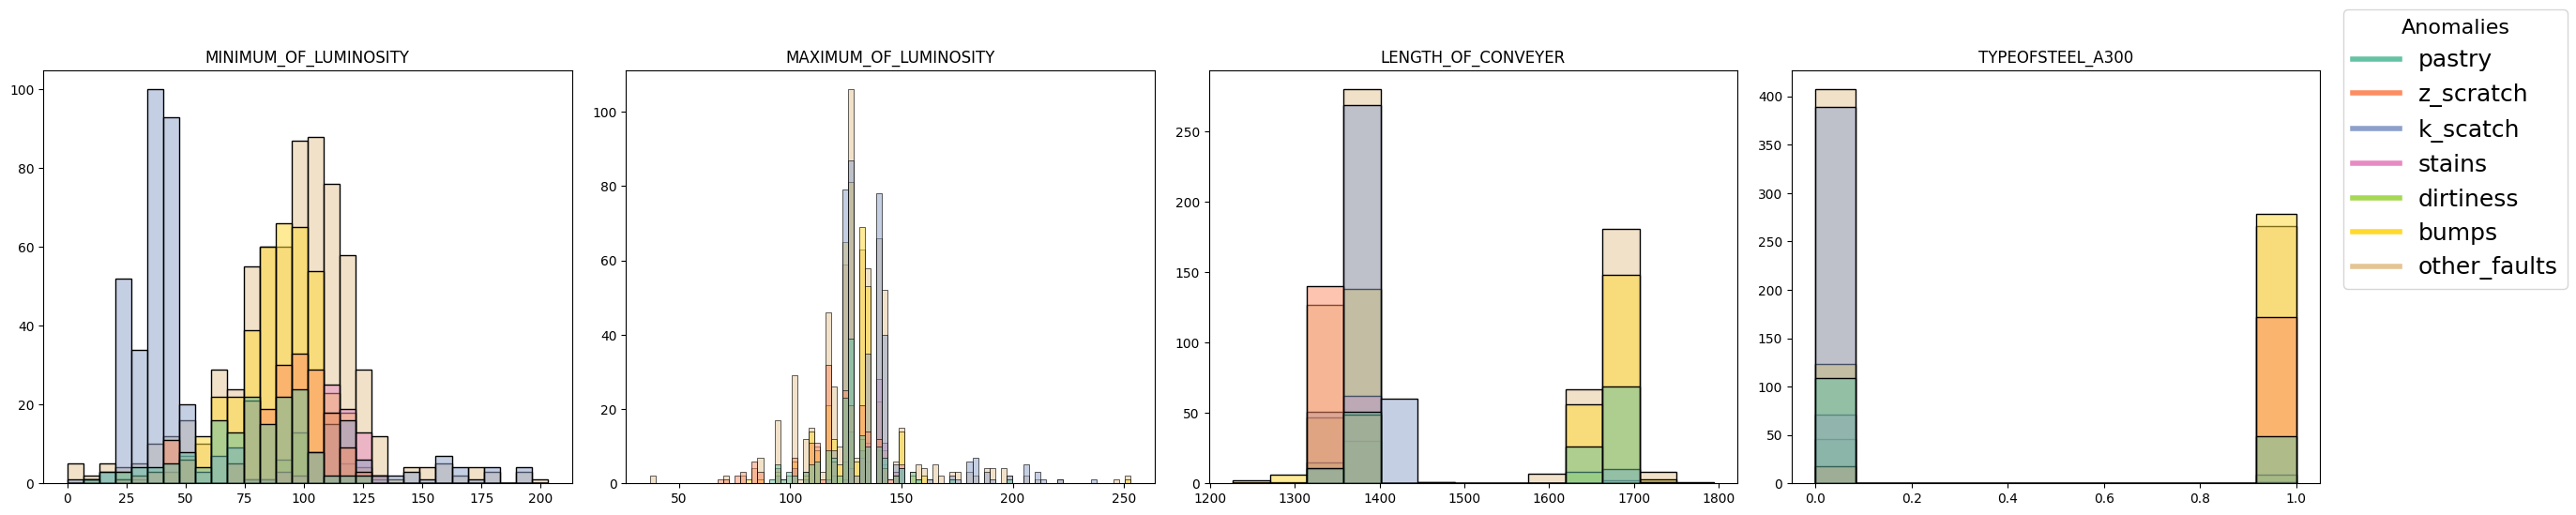

In [14]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

Lenght of conveyer has 2 distinct groups in the histogram, that's why it's an important feature.

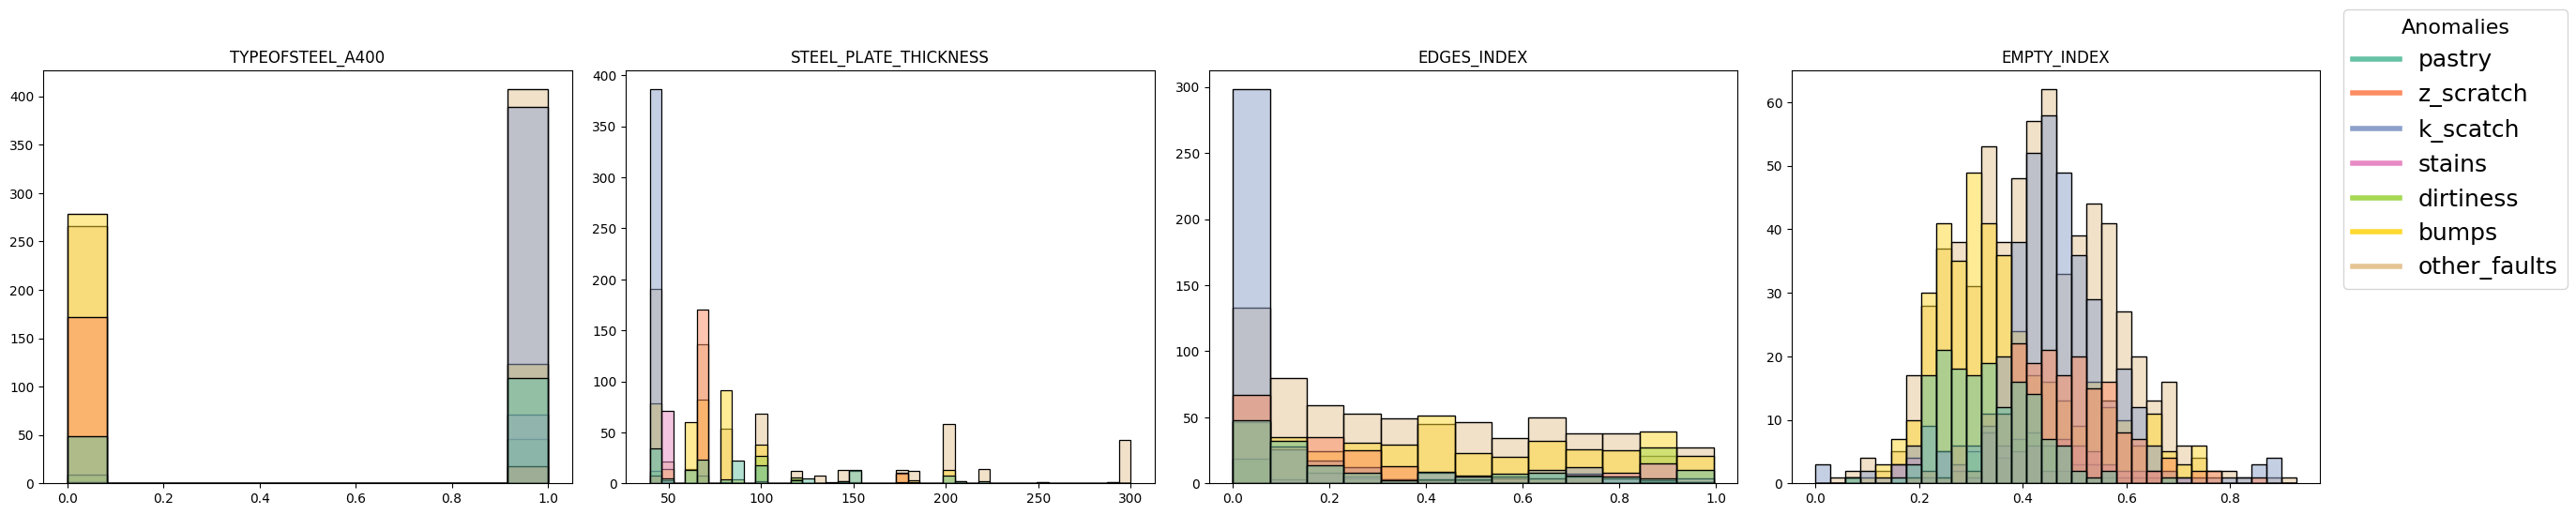

In [15]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

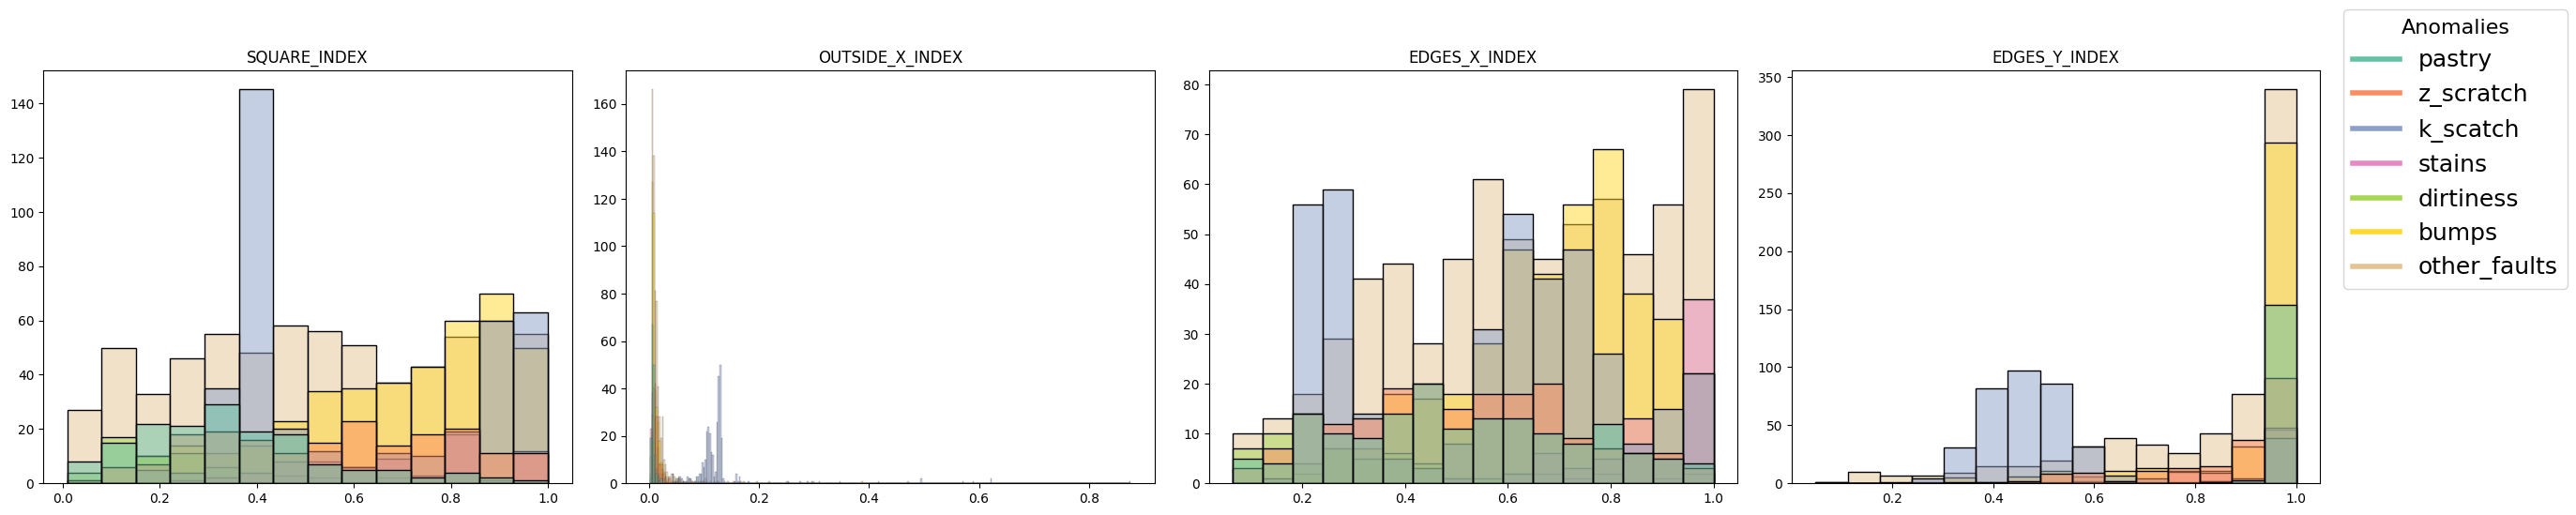

In [16]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

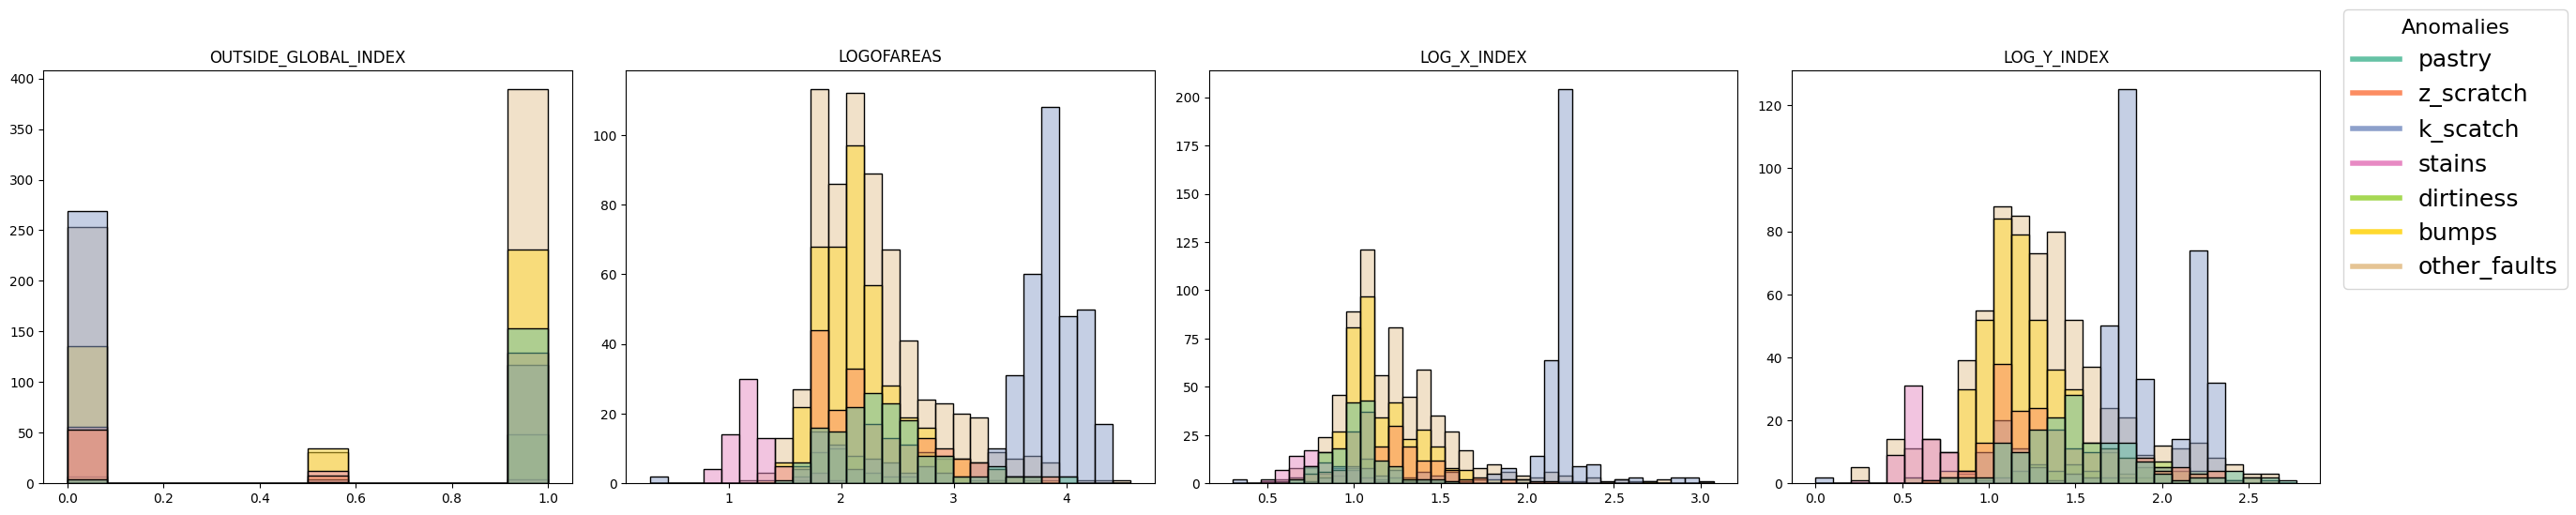

In [17]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

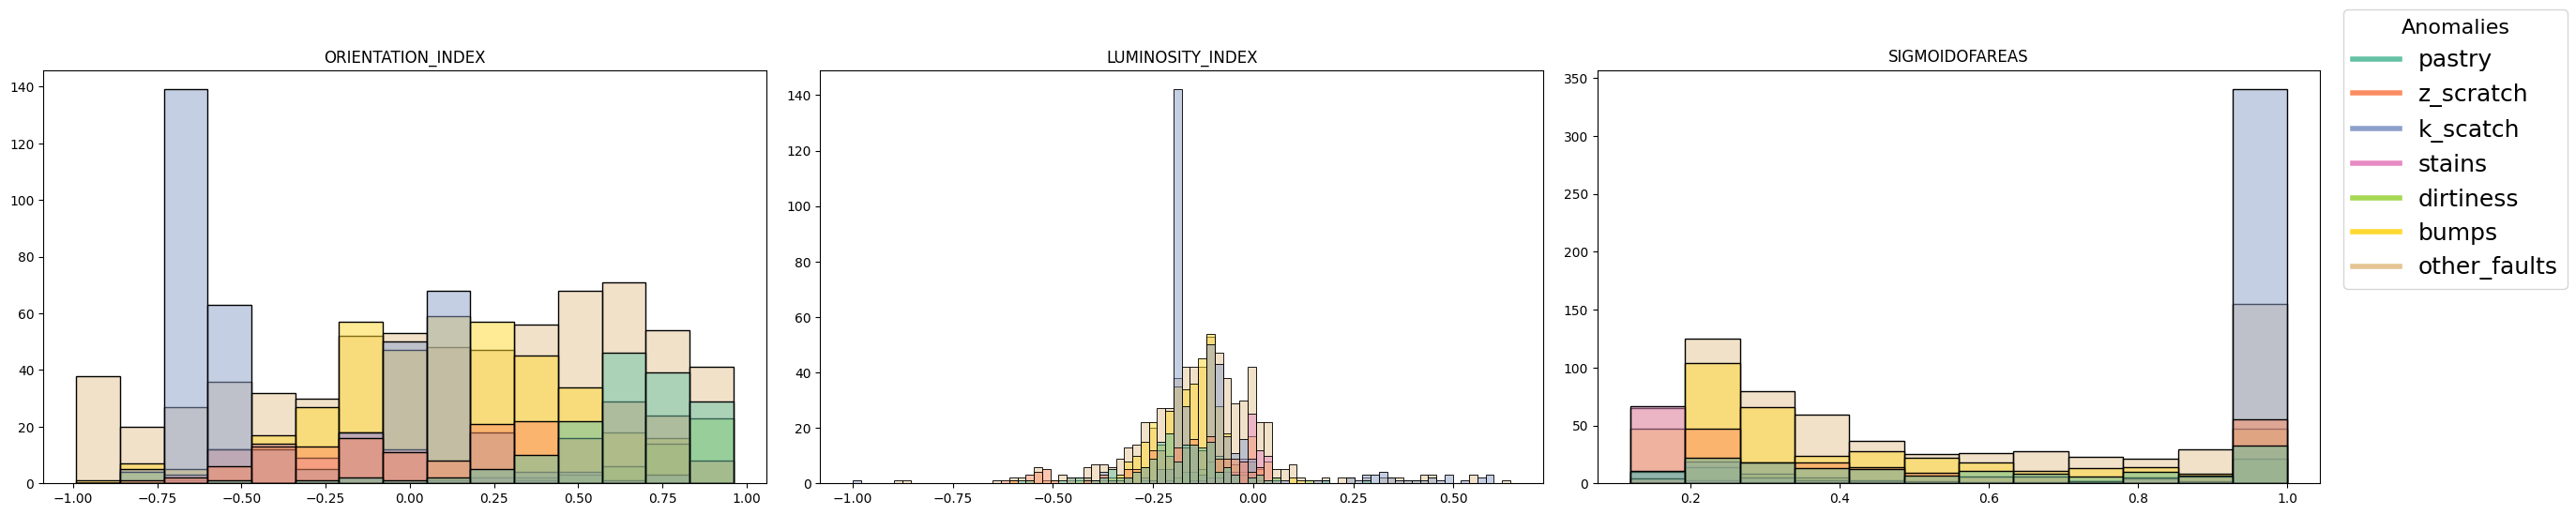

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

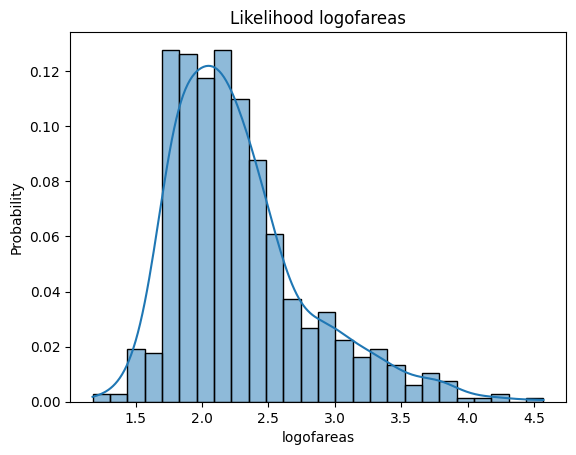

In [19]:
sns.histplot(df[df['anomaly'] == 6], x = 'logofareas', stat = 'probability', kde = True)
plt.title('Likelihood logofareas')
plt.show()

## Boxplots of the features

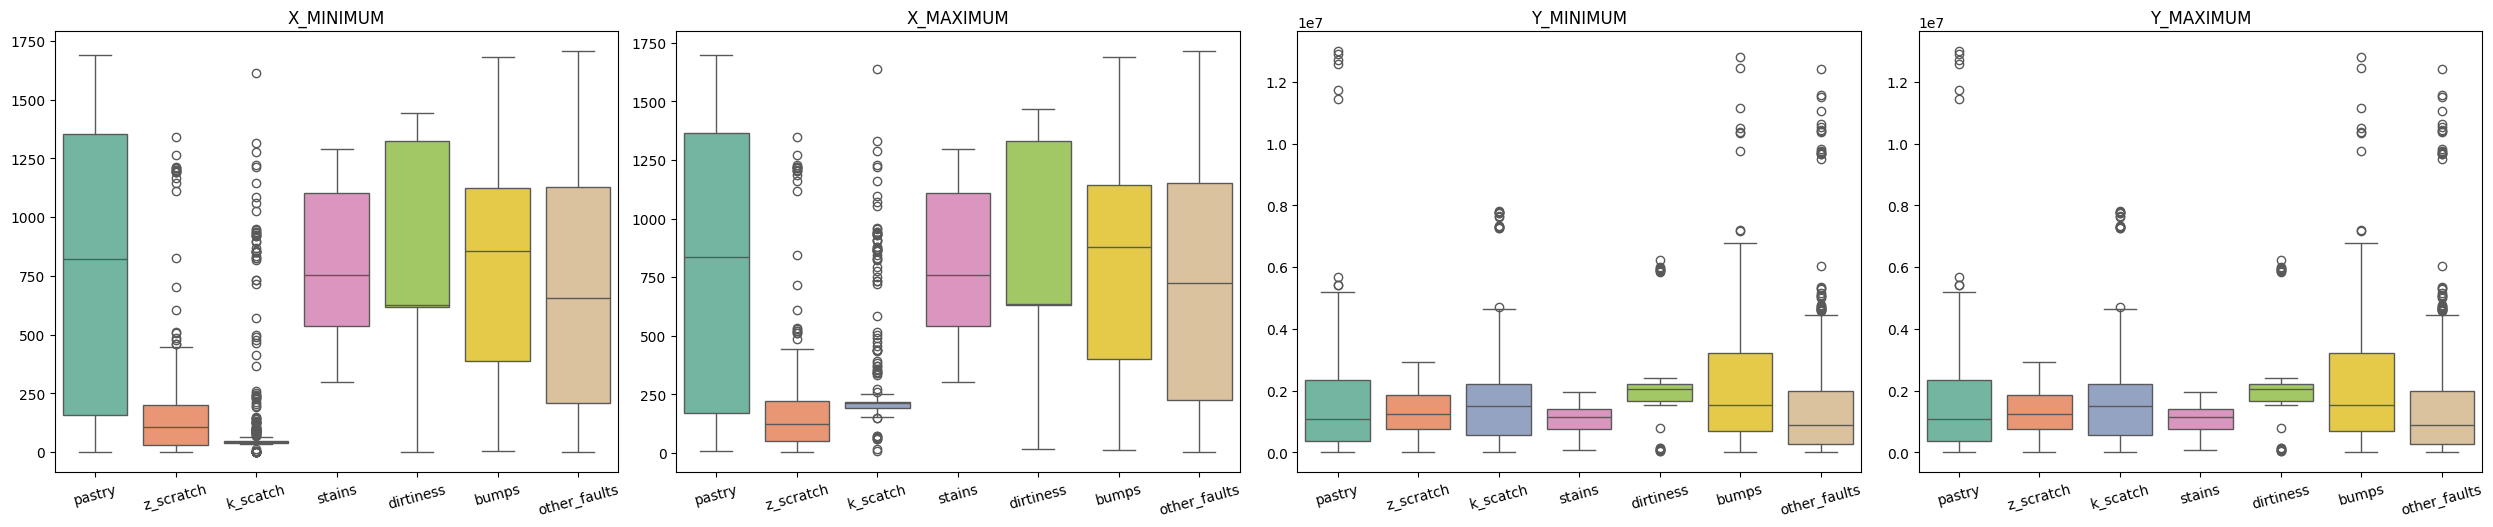

In [20]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[:4]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

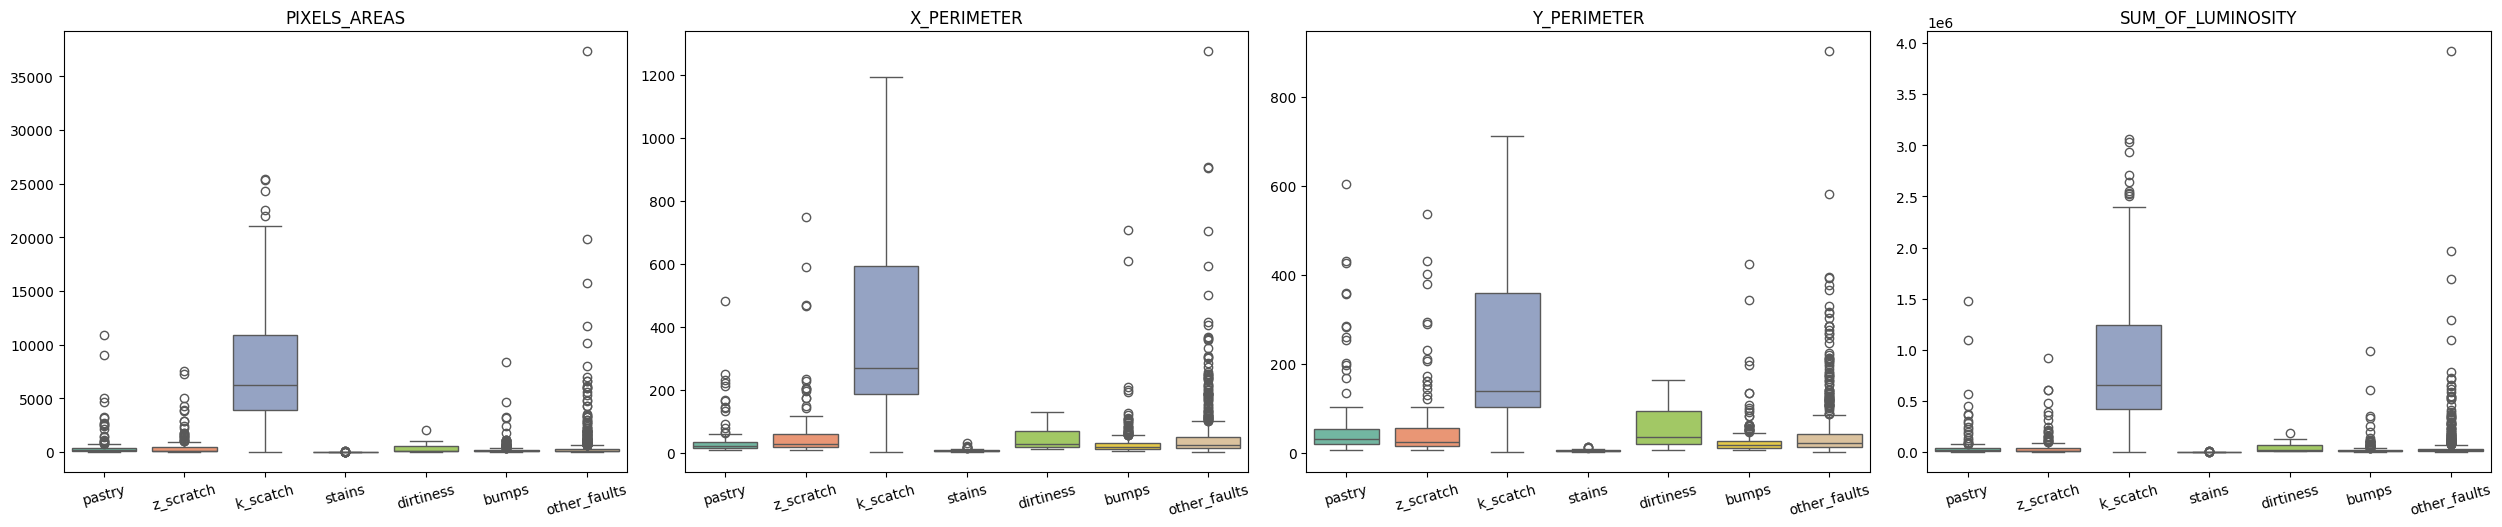

In [21]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

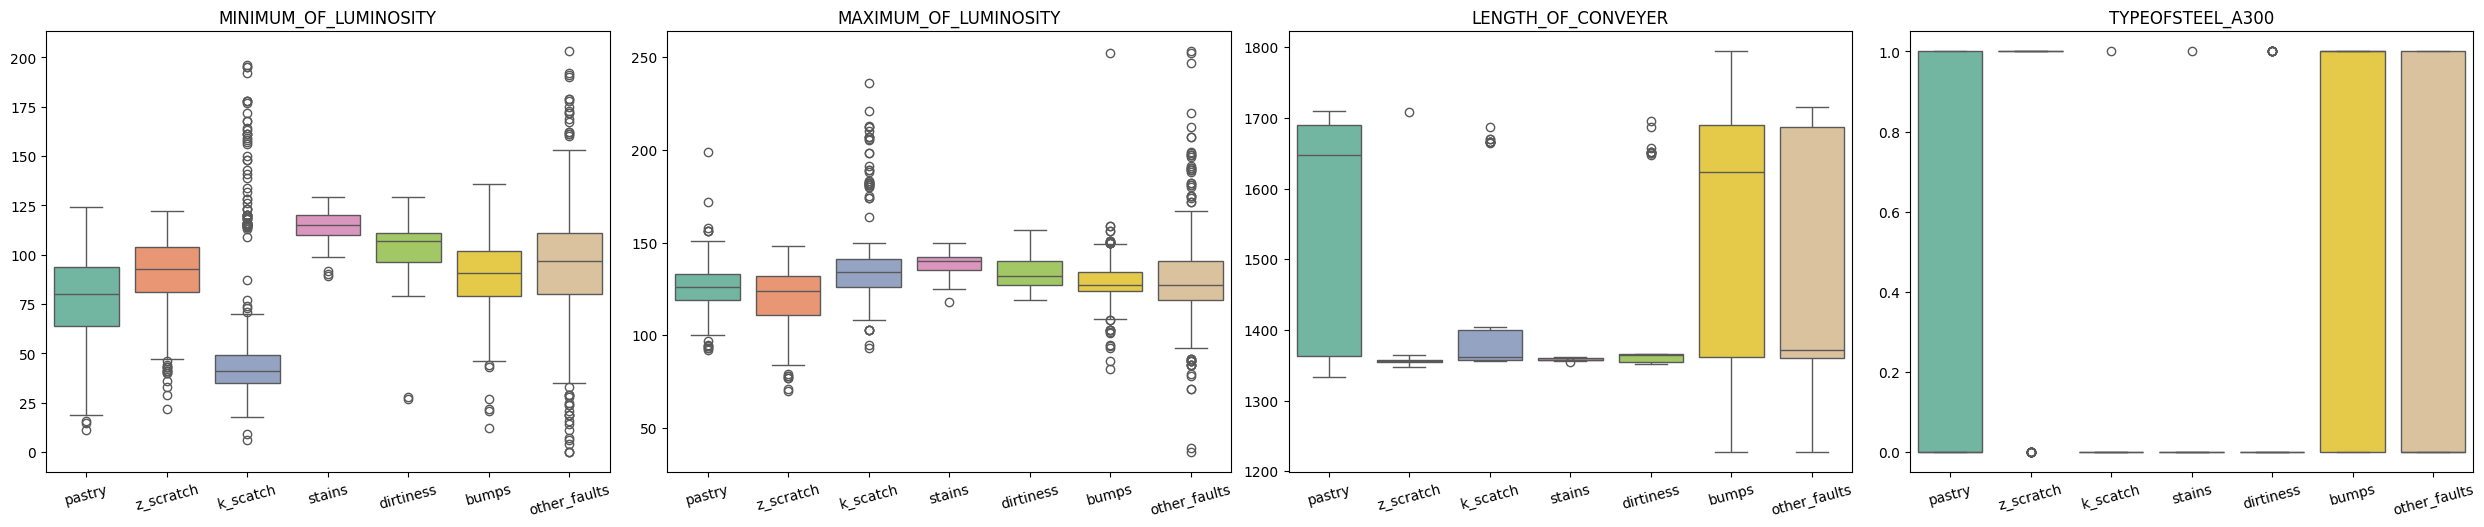

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

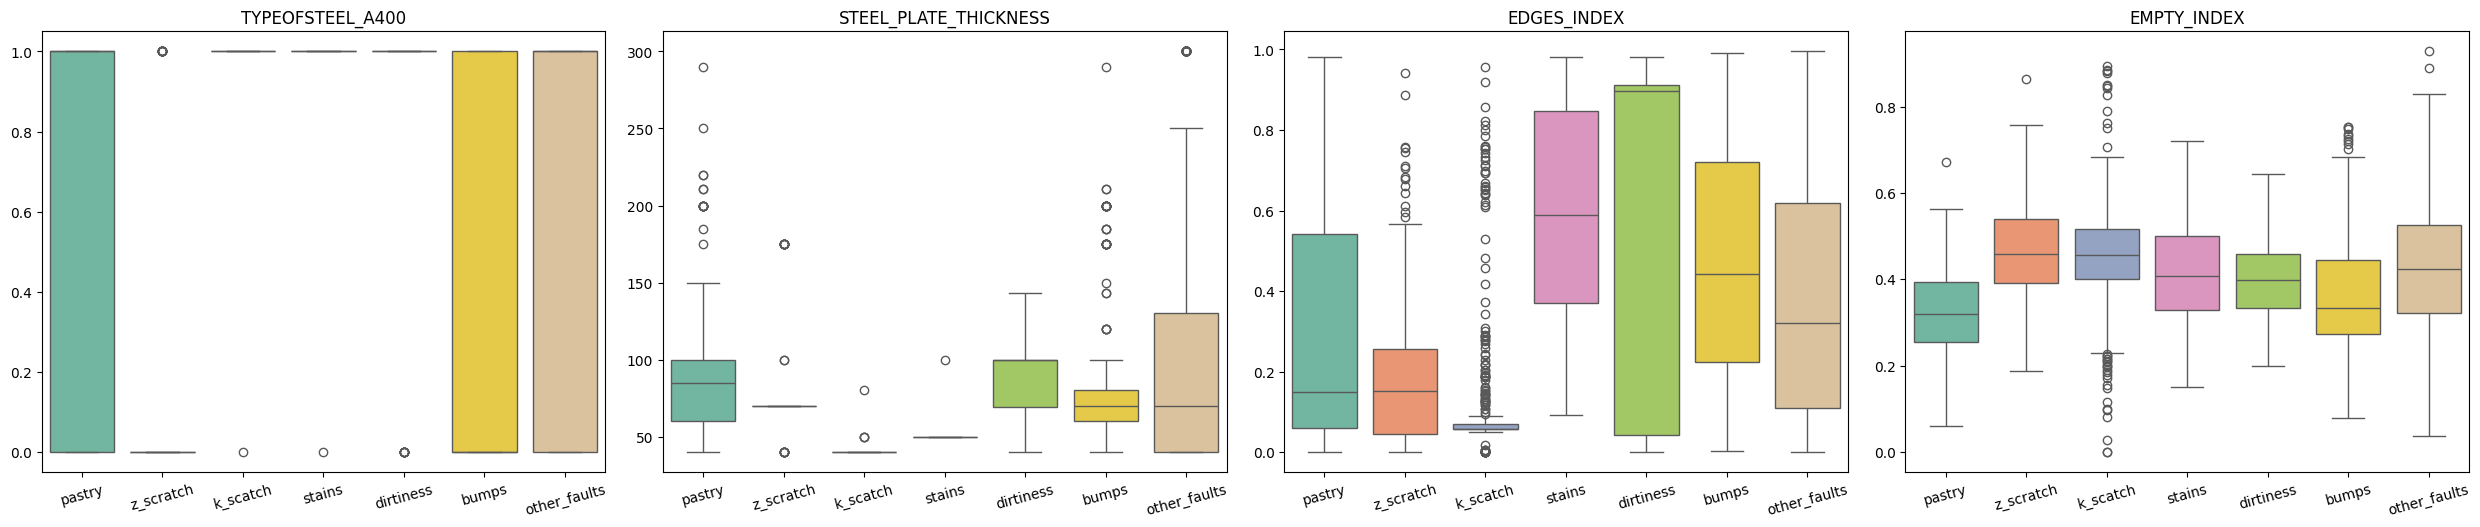

In [23]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

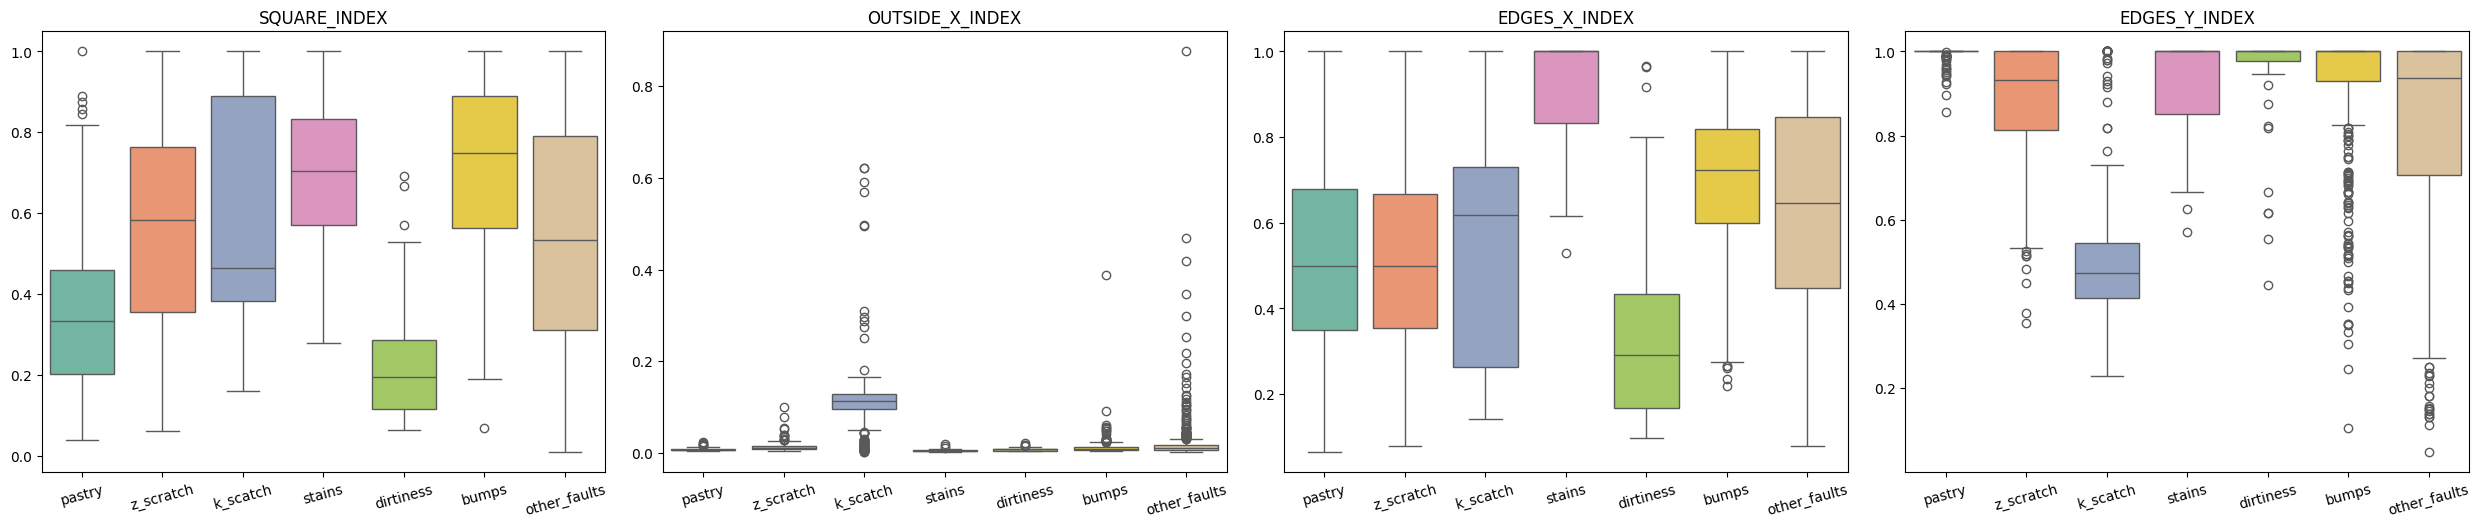

In [24]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

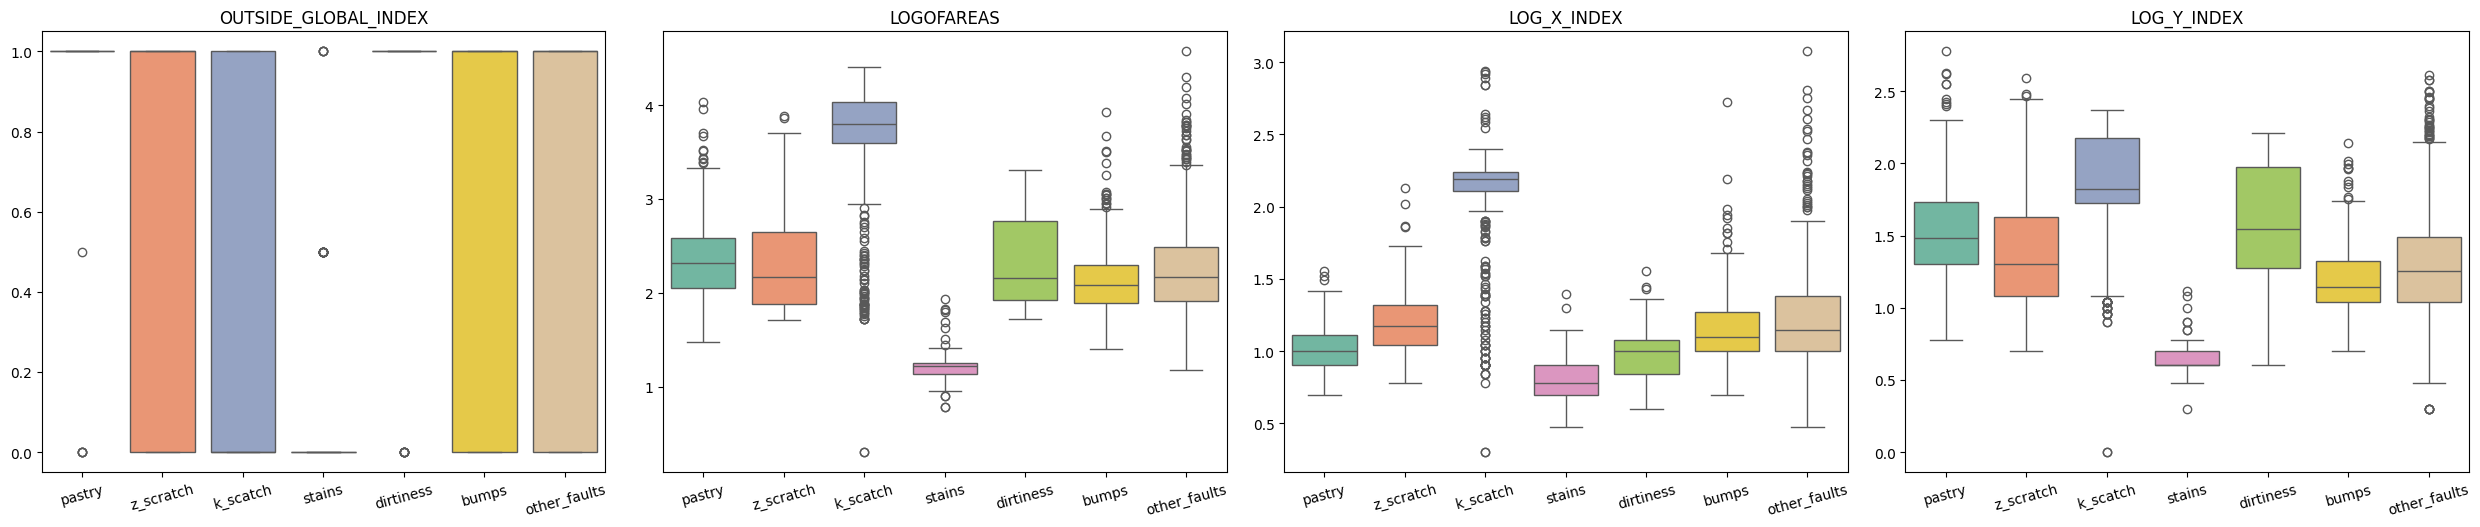

In [25]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

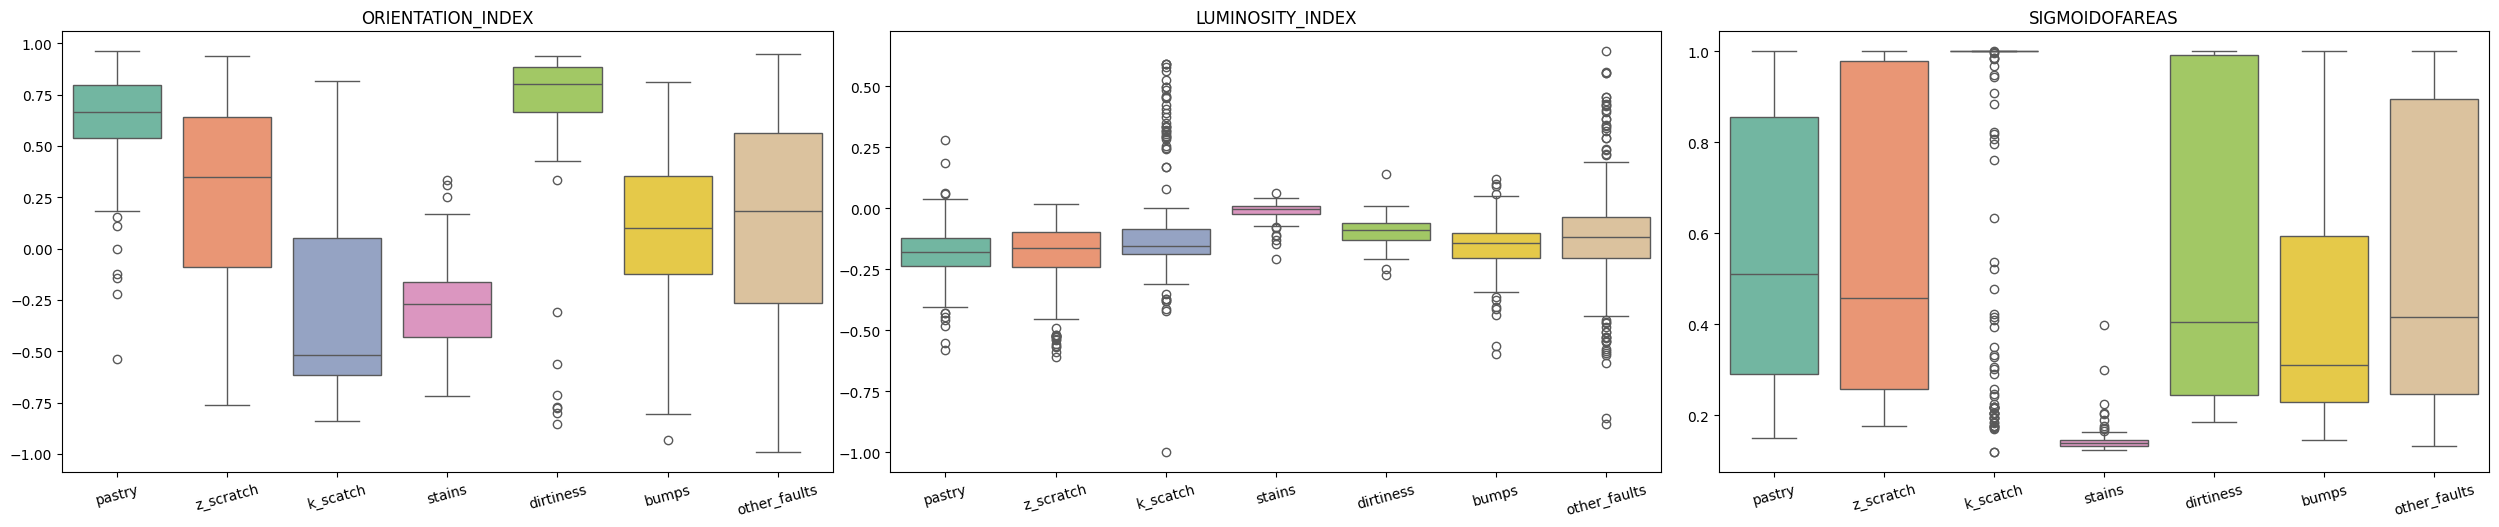

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

Check for binary features

In [27]:
for col in feat_col:
    if len(df[col].unique()) <= 2:
        print(f'Feature {col} has binary data (e.g. 0-1)')

# also check 'outside_global_index' feature
unique_ogi_feature = df['outside_global_index'].unique()
print(f'Feature outside_global_index has {len(unique_ogi_feature)} unique values, which are {str(unique_ogi_feature).strip("[").strip("]")}')

Feature typeofsteel_a300 has binary data (e.g. 0-1)
Feature typeofsteel_a400 has binary data (e.g. 0-1)
Feature outside_global_index has 3 unique values, which are 1.  0.5 0. 


# Balancing the classes

Display how the anomalies are divided in the dataset

In [28]:
anomaly_count = pd.DataFrame(df['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols
anomaly_count

,count
pastry,158
z_scratch,190
k_scatch,390
stains,72
dirtiness,55
bumps,402
other_faults,673


In [29]:
perc_first_3 = int(anomaly_count.loc[['other_faults', 'bumps', 'k_scatch']].sum()/anomaly_count.sum() * 100)
print(f'The first 3 anomalies count for {perc_first_3}% of the total anomalies')

The first 3 anomalies count for 75% of the total anomalies


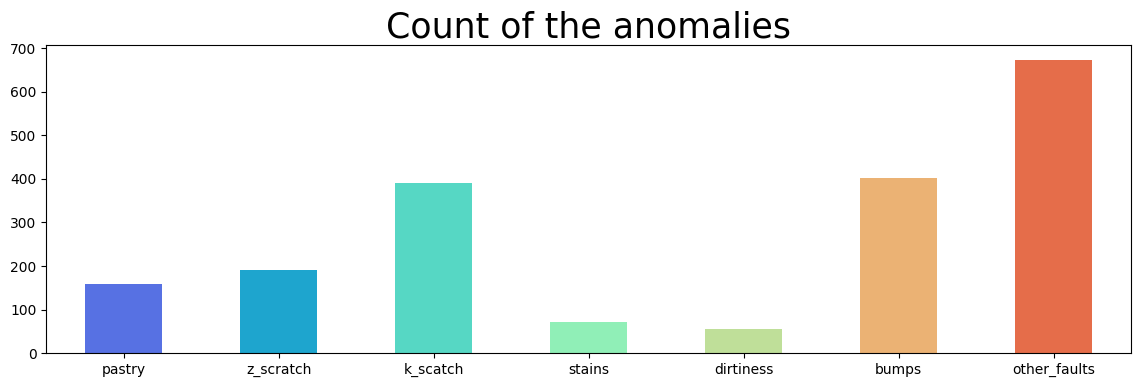

In [30]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count, x = anomaly_count.index, y = 'count', hue = anomaly_count.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [31]:
sm = SMOTE(random_state = 2)

In [32]:
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)

In [33]:
df_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)

In [34]:
anomaly_count_res = pd.DataFrame(df_res['anomaly'].value_counts()).sort_index()
anomaly_count_res.index = target_cols
anomaly_count_res

,count
pastry,673
z_scratch,673
k_scatch,673
stains,673
dirtiness,673
bumps,673
other_faults,673


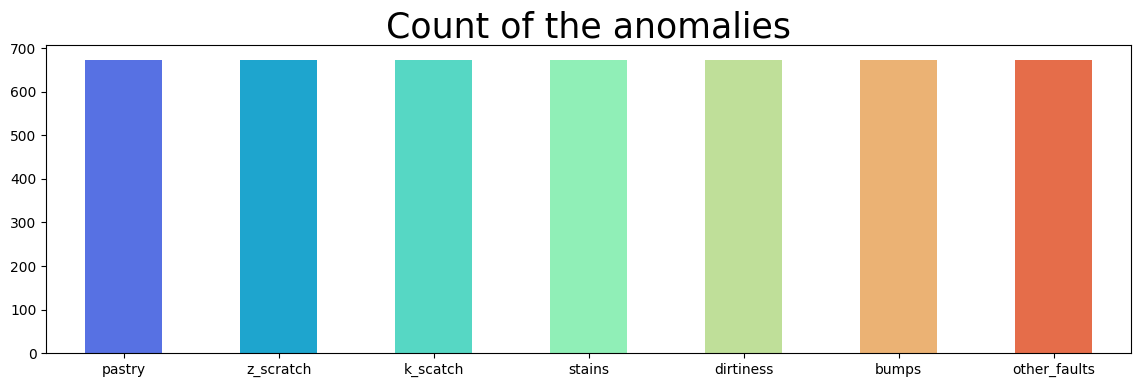

In [35]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count_res, x = anomaly_count_res.index, y = 'count', hue = anomaly_count_res.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

# Outlier detection 

From the boxplots we can clearly see that the dataset seems to present a lot of outliers. Check if these samples need to be removed or not

In [36]:
df_iqr = df.drop(target_cols, axis = 1)
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis = 1)]
df_iqr[target_cols] = df[target_cols]

In [37]:
anomaly_count_iqr = pd.DataFrame(df_iqr['anomaly'].value_counts()).sort_index()
anomaly_count_iqr
anomaly_count_iqr.index = target_cols
display(anomaly_count_iqr, anomaly_count_iqr - anomaly_count)
lost_samples = round((len(df) - len(df_iqr)) / len(df), 2) * 100
print(f"The dataset lost {lost_samples}% of it's samples")
del df_iqr, anomaly_count_iqr

,count
pastry,103
z_scratch,150
k_scatch,23
stains,72
dirtiness,46
bumps,334
other_faults,389


,count
pastry,-55
z_scratch,-40
k_scatch,-367
stains,0
dirtiness,-9
bumps,-68
other_faults,-284


The dataset lost 42.0% of it's samples


We can see that some anomalies are greatly affected by the IQR outlier deletion. Specifically, k_scratch which was one of the most represented in the dataset, lost 368 samples remaining with only 24. Since we loose a lot of representation, and also because such extreme values of the features specifically for k_scratch might not be casual and our models could theoretically learn this relation, choose to use the datasets without IQR applied. Also, 42% of the dataset would be lost if we applied this outlier detection.

# Correlation between features

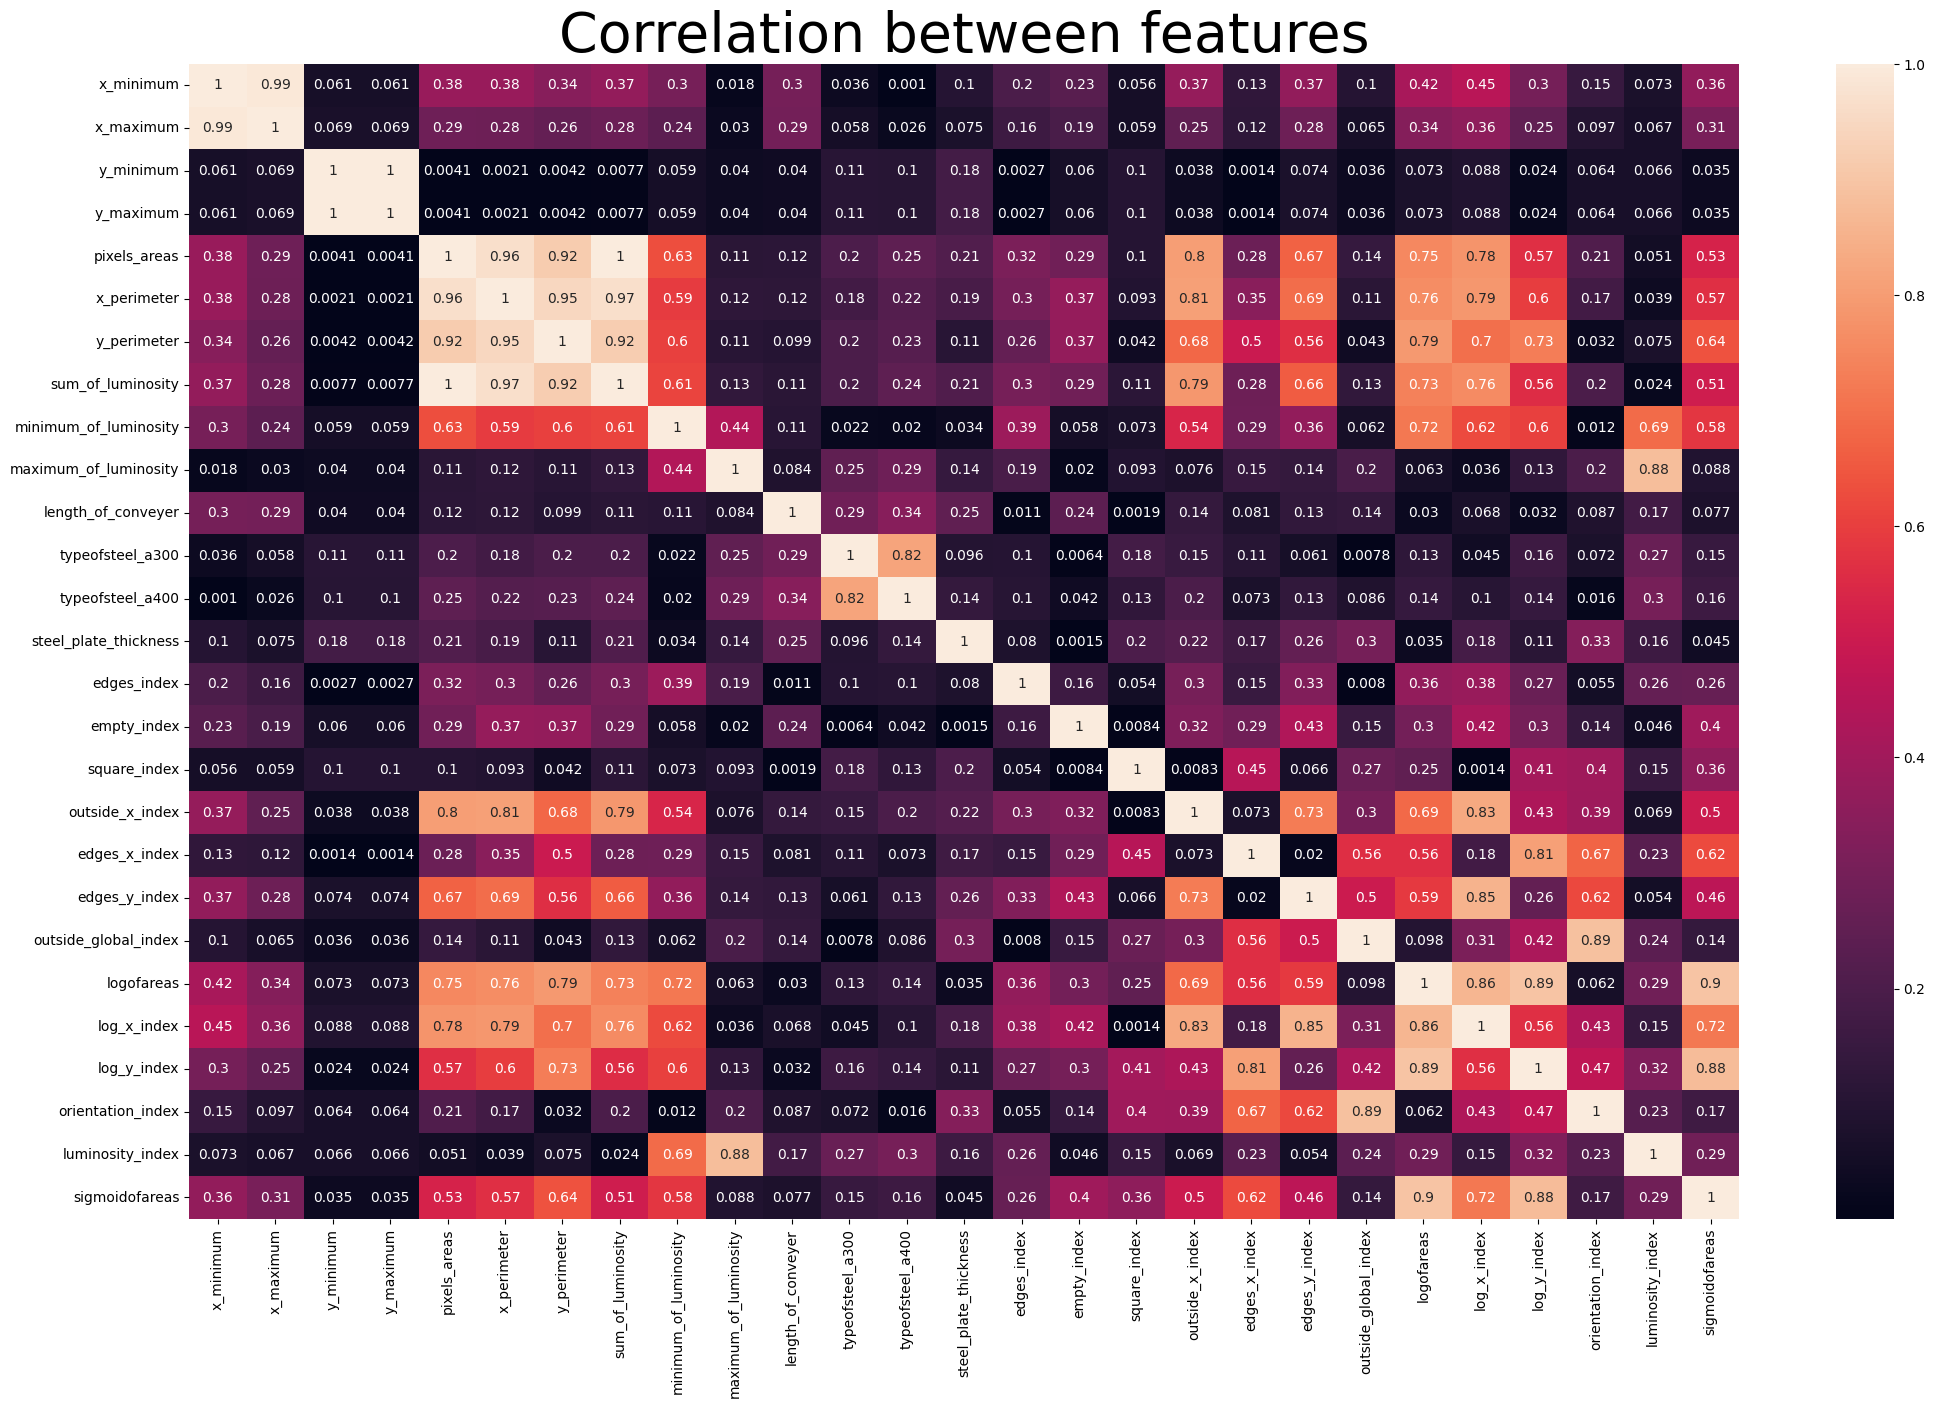

In [38]:
corr = df_res[feat_col].corr().abs()

plt.figure(figsize = (25, 15))
plt.title('Correlation between features', fontsize = 40)
sns.heatmap(corr, annot = True)#, cbar = False)
plt.show()

In [39]:
threshold = 0.7

mask = np.triu(np.ones(corr.shape), k=1)

# Find feature pairs with high correlation
high_corr_pairs = [
    (corr.index[i], corr.columns[j], corr.iloc[i, j])
    for i in range(corr.shape[0])
    for j in range(corr.shape[1])
    if mask[i, j] and corr.iloc[i, j] > threshold
]

high_corr_pairs = pd.DataFrame(high_corr_pairs).T
high_corr_pairs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,x_minimum,y_minimum,pixels_areas,pixels_areas,pixels_areas,pixels_areas,pixels_areas,pixels_areas,x_perimeter,x_perimeter,x_perimeter,x_perimeter,x_perimeter,y_perimeter,y_perimeter,y_perimeter,sum_of_luminosity,sum_of_luminosity,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,typeofsteel_a300,outside_x_index,outside_x_index,edges_x_index,edges_y_index,outside_global_index,logofareas,logofareas,logofareas,log_x_index,log_y_index
1,x_maximum,y_maximum,x_perimeter,y_perimeter,sum_of_luminosity,outside_x_index,logofareas,log_x_index,y_perimeter,sum_of_luminosity,outside_x_index,logofareas,log_x_index,sum_of_luminosity,logofareas,log_y_index,outside_x_index,logofareas,log_x_index,logofareas,luminosity_index,typeofsteel_a400,edges_y_index,log_x_index,log_y_index,log_x_index,orientation_index,log_x_index,log_y_index,sigmoidofareas,sigmoidofareas,sigmoidofareas
2,0.991419,1.0,0.964918,0.917614,0.997153,0.802441,0.753358,0.780978,0.94774,0.965571,0.80653,0.763547,0.786854,0.91996,0.792797,0.728227,0.788312,0.734751,0.76081,0.717861,0.880628,0.817277,0.725171,0.829903,0.808317,0.852329,0.888293,0.860946,0.894681,0.896106,0.718591,0.87667


We see that a lot of our features have high correlations between each others, particularly a lot of features have correlation higher than 0.33 (but even 0.7). This means we could use some feature engineering

Plot some relevant features (Pearson corr > 95%) so that we can better see their correlation

In [40]:
corr[corr > 0.95].replace({1.0 : np.nan}).dropna(how = 'all').dropna(axis = 1, how = 'all')

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,sum_of_luminosity
x_minimum,NaN,0.991419,NaN,NaN,NaN,NaN,NaN
x_maximum,0.991419,NaN,NaN,NaN,NaN,NaN,NaN
y_minimum,NaN,NaN,NaN,1.0,NaN,NaN,NaN
y_maximum,NaN,NaN,1.0,NaN,NaN,NaN,NaN
pixels_areas,NaN,NaN,NaN,NaN,NaN,0.964918,0.997153
x_perimeter,NaN,NaN,NaN,NaN,0.964918,NaN,0.965571
sum_of_luminosity,NaN,NaN,NaN,NaN,0.997153,0.965571,NaN


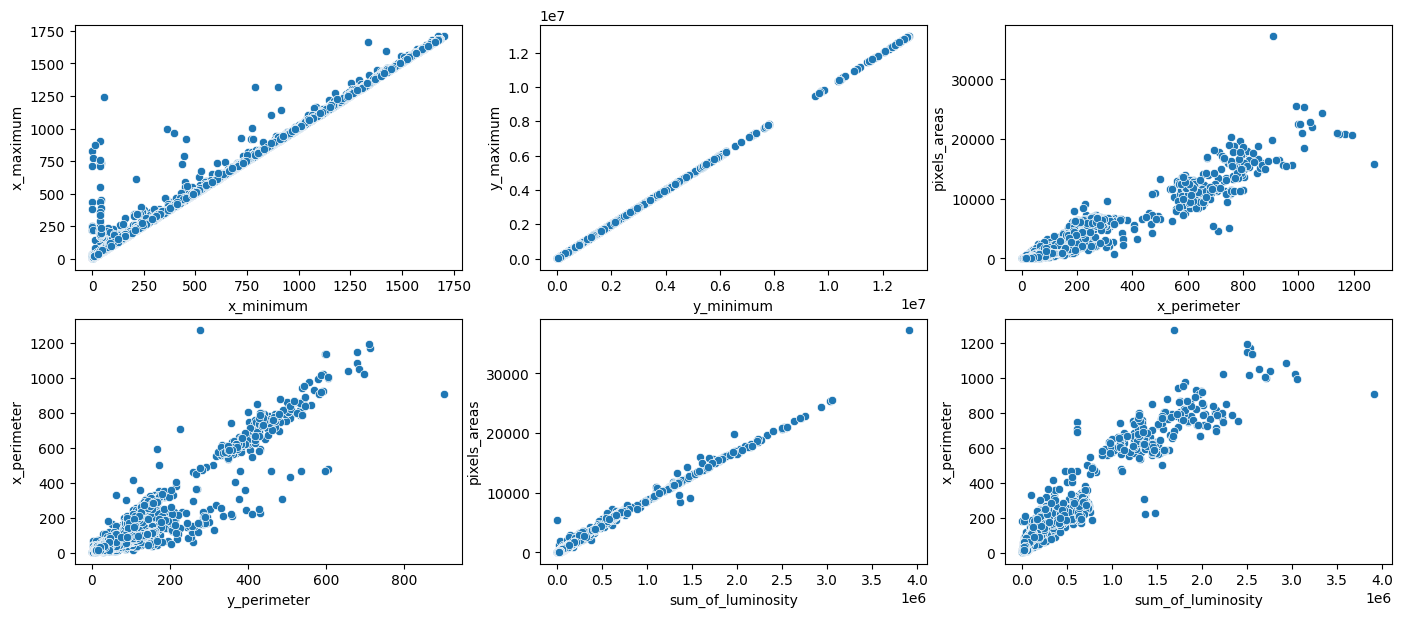

In [41]:
fig, ax = plt.subplots(2, 3, figsize = (17, 7))
plt.tight_layout

sns.scatterplot(data = df_res, x = 'x_minimum', y = 'x_maximum', ax = ax[0][0])
sns.scatterplot(data = df_res, x = 'y_minimum', y = 'y_maximum', ax = ax[0][1])
sns.scatterplot(data = df_res, x = 'x_perimeter', y = 'pixels_areas', ax = ax[0][2])
sns.scatterplot(data = df_res, x = 'y_perimeter', y = 'x_perimeter', ax = ax[1][0])
sns.scatterplot(data = df_res, x = 'sum_of_luminosity', y = 'pixels_areas', ax = ax[1][1])
sns.scatterplot(data = df_res, x = 'sum_of_luminosity', y = 'x_perimeter', ax = ax[1][2])

plt.show()

We clearly see a strong linearity between the features. Unfortunately, except x_minimum/x_maximum and y_minimum/y_maximum, all the other features are on very different range of data. This means that we can't use simple mean for aggregating some of these features. First, we will need to normalize the data via z-score, and then aggregate some features.

Later in the notebook, dimensionality reduction through UMAP is applied. Since UMAP handles well non-linear relationships, it might not be worth it trying to aggregate all of the highly correlated features. However, we will aggregate the ones displayed in the last graph, since they have almost perfect linear correlation and we will lower the feature dimension, making UMAP more computationally efficient while loosing very little information.

# Normalize the data

Since normalizing binary data doesn't make sense->remove the binary features, normalize the remaining features and then re-add the binary ones.

In [42]:
df_nonbin = df_res.drop(['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly'], axis = 1)#.drop(target_cols, axis = 1)

In [43]:
sc = StandardScaler()
# normalize the non binary dataframe
nonbin_norm = sc.fit_transform(df_nonbin)
# transform the standardized array into a dataframe
df_nonbin_norm = pd.DataFrame(nonbin_norm, columns = df_nonbin.columns)
# copy the non binary dataframe, so that we can add binary features to the new one
df_norm = df_nonbin_norm.copy()
df_norm[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']] = df_res[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']]
del nonbin_norm
df_norm.head()

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,length_of_conveyer,steel_plate_thickness,edges_index,empty_index,square_index,outside_x_index,edges_x_index,edges_y_index,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas,typeofsteel_a300,typeofsteel_a400,outside_global_index,anomaly
0,-1.174362,-1.281160,-0.819777,-0.819775,-0.327394,-0.404613,-0.180705,-0.330774,-0.456970,-1.434964,1.924163,0.131997,-1.022095,-1.387940,-1.306155,-0.416558,-0.482132,0.689158,0.142011,-0.667404,0.608245,1.288185,-1.331433,0.150662,1,0,1.0,0
1,0.070132,0.012387,0.505723,0.505715,-0.376688,-0.448175,-0.320455,-0.365572,-0.177419,-0.463655,1.924163,0.131997,1.296474,-0.236747,-1.212037,-0.439805,0.021701,0.525310,-0.358927,-0.946515,0.229621,1.238921,-0.428202,-0.695214,1,0,1.0,0
2,0.449878,0.408415,-0.069667,-0.069681,-0.388159,-0.460622,-0.430259,-0.374867,0.346739,-0.334147,1.429996,0.596089,1.965548,-0.543342,-0.738073,-0.437692,0.605744,0.430348,-0.590982,-0.946515,-0.203362,0.990835,-0.016011,-0.943790,1,0,1.0,0
3,0.499410,0.462223,-0.762206,-0.762205,-0.355606,-0.429506,-0.170723,-0.344950,0.346739,-0.269393,-0.654772,5.004966,1.179719,0.281206,-1.404397,-0.405990,-0.217756,0.689158,-0.088642,-0.797015,0.628525,1.339609,-0.281437,-0.031151,0,1,1.0,0
4,1.399244,1.422160,-0.686958,-0.686832,0.336676,-0.137018,1.975447,0.273607,-1.819781,-0.269393,-0.654772,2.568482,-0.958203,0.342191,-1.739622,-0.249596,-1.211407,0.632574,1.359377,0.064230,2.210553,1.515075,-0.612439,1.395928,0,1,1.0,0


In [44]:
# check for standardization
norm_dict = {}
for col in feat_col:
    norm_dict[col] = [round(df_norm[col].mean(), 5), round(df_norm[col].var(), 5)]
    if col == feat_col[-1]:
        display(pd.DataFrame(norm_dict, index = ['Mean', 'Variance']))

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,length_of_conveyer,typeofsteel_a300,typeofsteel_a400,steel_plate_thickness,edges_index,empty_index,square_index,outside_x_index,edges_x_index,edges_y_index,outside_global_index,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas
Mean,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.30652,0.60178,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,0.60193,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000
Variance,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,0.21261,0.23969,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,0.21014,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021


Data has been correcly standardized since the only features that don't have mean = 0 and variance = 1 are the binary features

# Aggregate features

Aggregate features that have high correlation

In [45]:
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum'], axis = 1, inplace = True)

df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)

df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)

df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)

df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)

df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

# Visualizing the classes

Perform a dimensionality reduction so that we can visualize the classes in a 3 dimensional space.

First try with PCA

In [46]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']

In [47]:
pca = PCA(n_components = 3)  
df_PCA = pca.fit_transform(X)
df_PCA = pd.DataFrame(df_PCA, columns = ['PC1', 'PC2', 'PC3'])
df_PCA['anomaly'] = df_norm['anomaly']

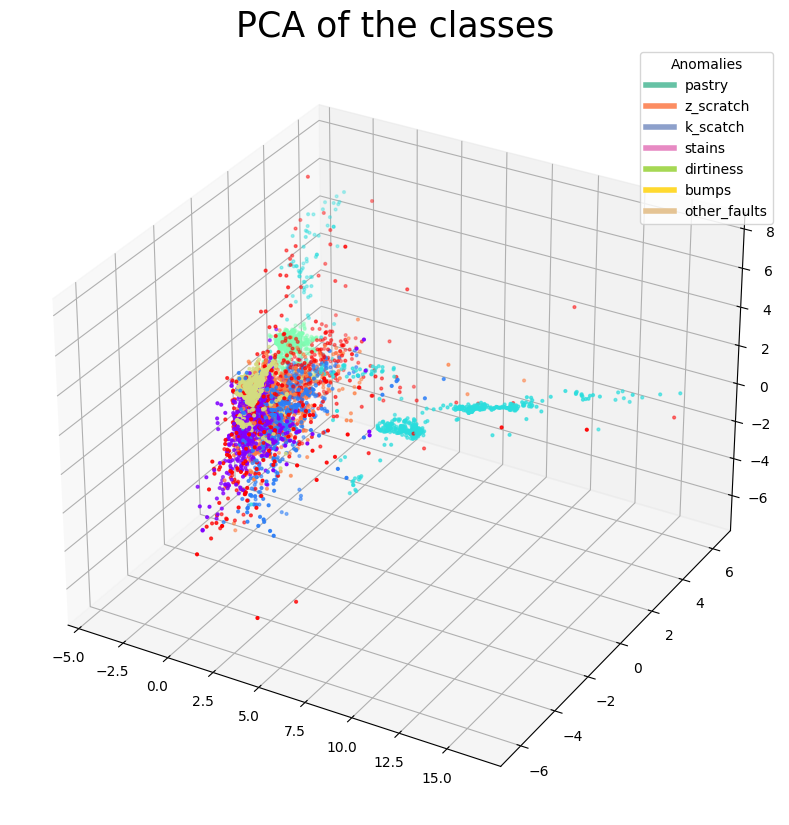

In [48]:
#%matplotlib qtagg 
# uncomment the previous line of code if you want to display interactive plot

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title('PCA of the classes', fontsize = 25)
cmap = ListedColormap(sns.color_palette('rainbow', 256).as_hex())

ax.scatter(xs = df_PCA['PC1'], ys = df_PCA['PC2'], zs = df_PCA['PC3'], c = df_PCA['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

Seems like PCA doesn't do a great job with this datasets when it comes to visualizing clusters of the classes, perhaps because of the non-linearity of the correlations between the features. 

t-SNE

In [50]:
tsne = TSNE(n_components = 3, random_state = 2)

df_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(df_tsne, columns = ['PC1', 'PC2', 'PC3'])
df_tsne['anomaly'] = df_norm['anomaly']

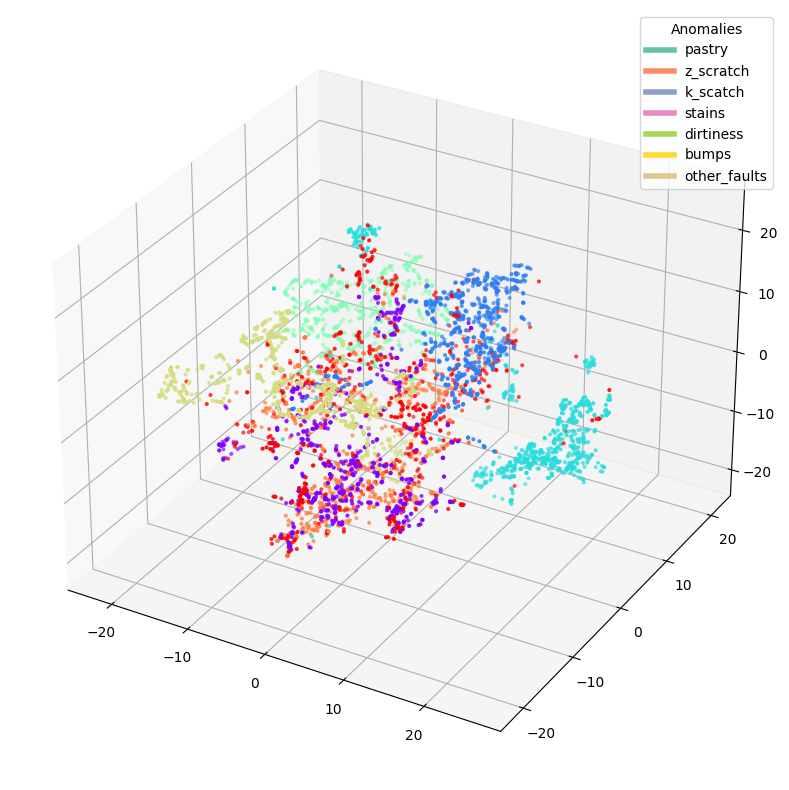

In [51]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')
cmap = ListedColormap(sns.color_palette('rainbow', 256).as_hex())

ax.scatter(df_tsne['PC1'], df_tsne['PC2'], df_tsne['PC3'], c = df_tsne['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

UMAP and t-SNE do a better job then PCA when it comes to dimensionality reduction while preserving the clusterization of the different classes. This implies non-linearity in the correlation between the features, and that it might be better to use the UMAP/t-SNE dimensionality reducted dataframes insteand of the original one or the PCA one.

In [52]:
df_norm = pd.read_csv('csv/balanced_normalized_steel_plates.csv', header = 0, index_col = 0)

# Models

In [53]:
metrics_df = pd.DataFrame([], columns = ['ACCURACY', 'PRECISION', 'RECALL', 'F1'])
metrics_df

,ACCURACY,PRECISION,RECALL,F1


## Naive Bayes

Without preprocessing

In [54]:
gnb = GaussianNB()

In [55]:
X_full = df[feat_col]
y_full = df['anomaly']
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, test_size = 0.3, random_state = 2)

In [56]:
gnb.fit(X_full_train, y_full_train)
y_pred = gnb.predict(X_full_test)

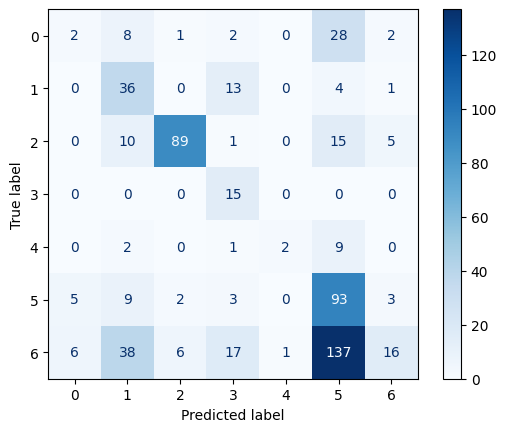

In [58]:
#matplotlib.use('inline')
cm = confusion_matrix(y_full_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
plt.show()

In [60]:
gnb_raw_accuracy = f'{round(accuracy_score(y_full_test, y_pred) * 100, 2)}%'
gnb_raw_precision = f'{round(precision_score(y_full_test, y_pred, average = "macro") * 100, 2)}%'
gnb_raw_recall = f'{round(recall_score(y_full_test, y_pred, average = "macro") * 100, 2)}%'
gnb_raw_f1 = f'{round(f1_score(y_full_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for naive bayes classifier: {gnb_raw_accuracy}')
metrics_df.loc['Raw Gnb'] = [gnb_raw_accuracy, gnb_raw_precision, gnb_raw_recall, gnb_raw_f1]

Accuracy score for naive bayes classifier: 43.47%


In [61]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%


With preprocessing

In [62]:
gnb = GaussianNB()

In [63]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [64]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

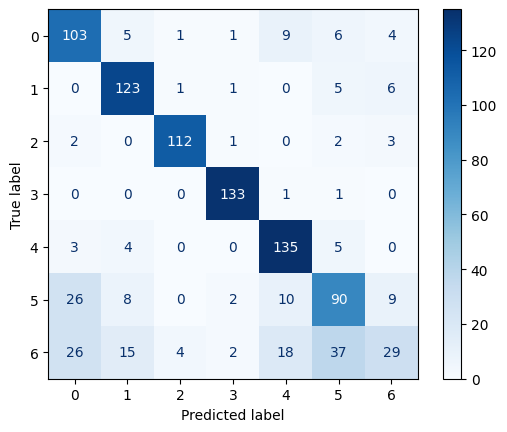

In [65]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
plt.show()

In [66]:
gnb_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
gnb_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
gnb_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
gnb_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for naive bayes classifier: {gnb_accuracy}')
metrics_df.loc['Gnb'] = [gnb_accuracy, gnb_precision, gnb_recall, gnb_f1]

Accuracy score for naive bayes classifier: 76.88%


In [67]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%
Gnb,76.88%,75.74%,76.88%,74.97%


As we've seen in the UMAP visualization of the classes, class 5 and 6 are difficultly differentiable. This is confirmed by the the latter confusion matrix. We might try using some hyperparameter tuning/priors/loss balanced learning in the case of the naive bayes classifier

## Support Vector Classifier

Without parameter hypertuning

In [68]:
svm = SVC()

In [69]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

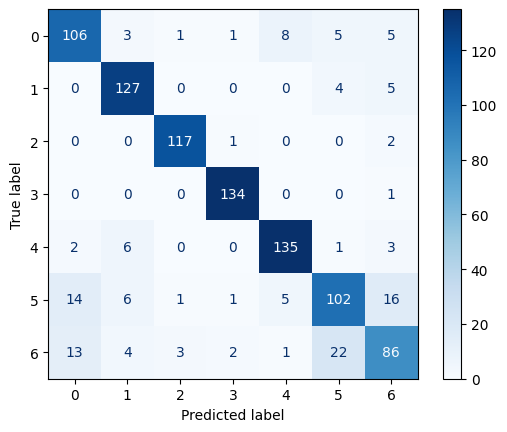

In [70]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
plt.show()

In [71]:
svm_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
svm_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
svm_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
svm_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for SVM classifier: {svm_accuracy}')
metrics_df.loc['SVM'] = [svm_accuracy, svm_precision, svm_recall, svm_f1]

Accuracy score for SVM classifier: 85.58%


In [72]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%
Gnb,76.88%,75.74%,76.88%,74.97%
SVM,85.58%,85.34%,85.73%,85.47%


Hyperparameter tuning for SVM

In [73]:
parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

svc = SVC()

clf = GridSearchCV(svc, parameters, scoring = 'accuracy', refit = True, verbose = 1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [74]:
y_pred = clf.predict(X_test)

In [75]:
clf.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

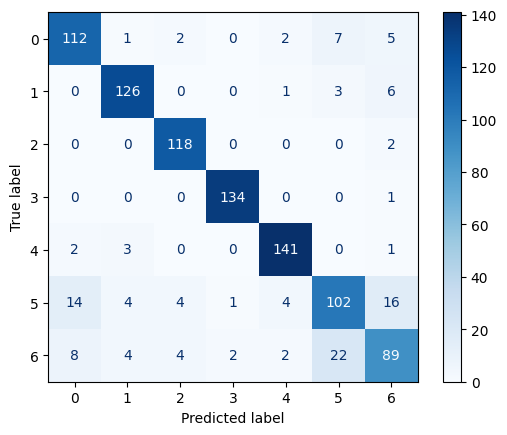

In [76]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
plt.show()

In [77]:
svm_g_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
svm_g_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
svm_g_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
svm_g_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for SVM classifier: {svm_g_accuracy}')
metrics_df.loc['Hyp. Tuning SVM'] = [svm_g_accuracy, svm_g_precision, svm_g_recall, svm_g_f1]

Accuracy score for SVM classifier: 87.17%


In [78]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%
Gnb,76.88%,75.74%,76.88%,74.97%
SVM,85.58%,85.34%,85.73%,85.47%
Hyp. Tuning SVM,87.17%,86.85%,87.32%,87.02%


## Neural Network Classifier

DA VEDERE https://www.tensorflow.org/tutorials/keras/keras_tuner

2025-02-12 14:42:11.196357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-12 14:42:11.220925: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4848380386829376; accuracy of 85.68%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.4319864809513092; accuracy of 85.41%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.3950929641723633; accuracy of 87.4%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.45611998438835144; accuracy of 83.53%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.4484664797782898; accuracy of 84.33%
30/30 [==============================] - 0s 2ms/step
Accuracy score for NN classifier: 92.26%

Classification Report:
               precision    recall  f1-score   support

           0    

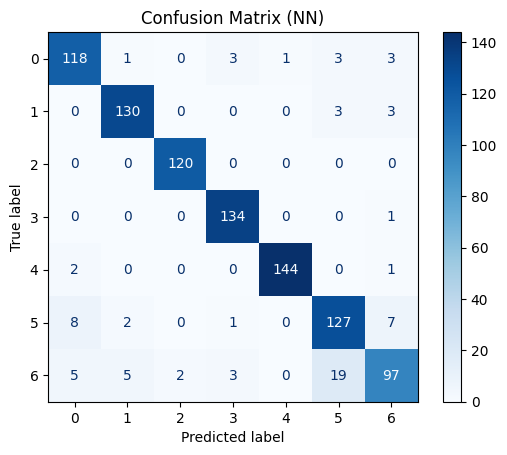

In [79]:
# Define the K-fold Cross Validator
num_plits = 5
kfold = KFold(n_splits = num_plits, shuffle = True)

acc_per_fold = []
loss_per_fold = []
best_score = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):
      
  # Define the model architecture
  input_layer = Input(shape = (X.shape[1],))
  x = Dense(128, activation=None, kernel_initializer = GlorotNormal())(input_layer)
  x = LeakyReLU(trainable = True)(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = Dense(64, activation=None, kernel_initializer = GlorotNormal())(x)
  x = LeakyReLU(trainable = True)(x)
  x = Dense(32, activation=None, kernel_initializer = GlorotNormal())(x)
  x = LeakyReLU(trainable = True)(x)
  x = Dense(16, activation=None, kernel_initializer = GlorotNormal())(x)
  x = LeakyReLU(trainable = True)(x)
  output_classification = Dense(7, activation = "softmax", kernel_initializer = GlorotNormal(), name = "classification")(x)
  model = Model(inputs = input_layer, outputs = output_classification)
  model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
   # Fit data to model
  history = model.fit(X.iloc[train], y.iloc[train],
              batch_size = 256,
              epochs = 100,
              verbose = 0)
   # Generate generalization metrics
  scores = model.evaluate(X.iloc[test], y.iloc[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {round(scores[1]*100, 2)}%')
  acc_per_fold.append(round(scores[1], 2) * 100)
  loss_per_fold.append(scores[0])
  if scores[1] > best_score:
    best_model = model
    best_score = scores[1]
  
  if fold_no == num_plits:
    y_pred = best_model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    nn_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
    nn_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
    nn_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
    nn_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
    print(f'Accuracy score for NN classifier: {nn_accuracy}')
    metrics_df.loc['FF Neural Network'] = [nn_accuracy, nn_precision, nn_recall, nn_f1]
     # Classification report and confusion matrix
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix (NN)")
    plt.show()
   # Increase fold number
  fold_no = fold_no + 1

In [80]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%
Gnb,76.88%,75.74%,76.88%,74.97%
SVM,85.58%,85.34%,85.73%,85.47%
Hyp. Tuning SVM,87.17%,86.85%,87.32%,87.02%
FF Neural Network,92.26%,92.26%,92.27%,92.18%


## Autoencoder feature extraction SVM classifier

In [81]:
y_cat = tf.keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.2)

In [82]:
# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 10

# Define the Functional API model
inputs = Input(shape=(input_dim,))
x = GaussianNoise(0.2)(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

bottleneck = Dense(encoding_dim, activation='relu', name='bottleneck')(x)

x = Dense(64, activation='relu')(bottleneck)
x = Dense(128, activation='relu')(x)
outputs = Dense(input_dim, activation='relu')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mae')

# Extract the encoder
encoder = Model(inputs, bottleneck)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24)]              0         
                                                                 
 gaussian_noise (GaussianNo  (None, 24)                0         
 ise)                                                            
                                                                 
 dense_20 (Dense)            (None, 128)               3200      
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 bottleneck (Dense)          (None, 10)                650       
                                                                 
 dense_22 (Dense)            (None, 64)                704       
                                                           

In [83]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights = True)

history = model.fit(X_train, X_train, 
                    epochs = 500, 
                    batch_size = 256, 
                    shuffle = True, 
                    validation_data = (X_test, X_test), 
                    verbose = 0,
                    callbacks = [earlystop])

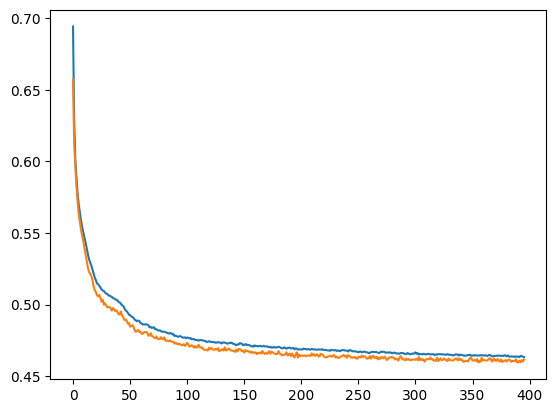

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.show()

In [85]:
sc = StandardScaler()

# Use encoder part of the autoencoder for feature selection
encoder = Model(inputs = model.input, outputs = model.get_layer('bottleneck').output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)
encoded_features_train = sc.fit_transform(encoded_features_train)
encoded_features_test = sc.fit_transform(encoded_features_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)

30/30 [==============================] - 0s 992us/step
Encoded Features Shape (Train): (3768, 10)
Encoded Features Shape (Test): (943, 10)


In [86]:
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)

# Initialize the SVM classifier
svm_classifier = SVC(kernel = 'rbf', random_state = 42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', refit = True, verbose = 1)
grid.fit(encoded_features_train, y_train)
y_pred = grid.predict(encoded_features_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [87]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

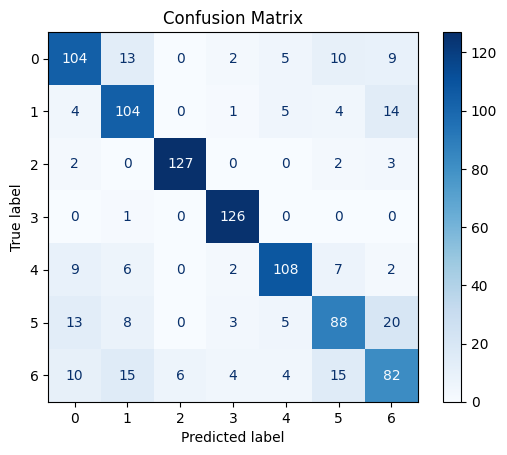

In [88]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = grid.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [89]:
ae_svm_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
ae_svm_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
ae_svm_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
ae_svm_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for SVM classifier with autoencoder dimensionality reduction: {ae_svm_accuracy}')
metrics_df.loc['SVM AutoEncoder dim. reduction'] = [ae_svm_accuracy, ae_svm_precision, ae_svm_recall, ae_svm_f1]

Accuracy score for SVM classifier with autoencoder dimensionality reduction: 78.37%


In [90]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%
Gnb,76.88%,75.74%,76.88%,74.97%
SVM,85.58%,85.34%,85.73%,85.47%
Hyp. Tuning SVM,87.17%,86.85%,87.32%,87.02%
FF Neural Network,92.26%,92.26%,92.27%,92.18%
SVM AutoEncoder dim. reduction,78.37%,78.39%,78.66%,78.44%


## Autoencoder classifier

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [92]:
# Input layer
input_layer = Input(shape=(X.shape[1],))

# Encoder: trasformazione verso lo spazio latente
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)


# Decoder: ricostruzione dei dati
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
output_reconstruction = Dense(X.shape[1], activation = 'relu', name = "reconstruction")(decoded)

# Classifier: predizione della classe
output_classification = Dense(7, activation = 'softmax', name = "classification")(encoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=[output_reconstruction, output_classification])
classification = Model(inputs = input_layer, outputs = output_classification)

# Compile the model with a combined loss
autoencoder.compile(
    optimizer = 'adam',
    loss = {
        "reconstruction": "mse",
        "classification": 'sparse_categorical_crossentropy'
    },
    loss_weights={"reconstruction": 0.5, "classification": 0.5},
    metrics = ['mse', 'accuracy']
)

# Train the autoencoder
history = autoencoder.fit(
    X_train, [X_train, y_train],  # Input: X, Outputs: [reconstruction, classification]
    batch_size = 256,
    epochs = 100,
    shuffle = True,
    validation_split = 0.2
)

Epoch 1/100
12/12 [==============================] - 2s 44ms/step - loss: 1.3273 - reconstruction_loss: 0.8873 - classification_loss: 1.7674 - reconstruction_mse: 0.8873 - reconstruction_accuracy: 0.0279 - classification_mse: 12.0194 - classification_accuracy: 0.4383 - val_loss: 1.1824 - val_reconstruction_loss: 0.7969 - val_classification_loss: 1.5680 - val_reconstruction_mse: 0.7969 - val_reconstruction_accuracy: 0.0252 - val_classification_mse: 12.4388 - val_classification_accuracy: 0.5915
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 0.9932 - reconstruction_loss: 0.7514 - classification_loss: 1.2351 - reconstruction_mse: 0.7514 - reconstruction_accuracy: 0.0962 - classification_mse: 12.0439 - classification_accuracy: 0.6148 - val_loss: 0.8016 - val_reconstruction_loss: 0.7213 - val_classification_loss: 0.8820 - val_reconstruction_mse: 0.7213 - val_reconstruction_accuracy: 0.2334 - val_classification_mse: 12.4785 - val_classification_accuracy: 0.6883
Epoc

In [93]:
# Define encoder model to extract latent features
encoder = Model(inputs = autoencoder.input, outputs = encoded)

# Generate latent representations
latent_features = encoder.predict(X_train)
latent_features_test = encoder.predict(X_test)
latent_features = sc.fit_transform(latent_features)
latent_features_test = sc.fit_transform(latent_features_test)

30/30 [==============================] - 0s 2ms/step


30/30 [==============================] - 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       129
           1       0.90      0.86      0.88       136
           2       0.92      0.98      0.95       120
           3       0.96      0.99      0.97       135
           4       0.96      0.92      0.94       147
           5       0.75      0.70      0.73       145
           6       0.68      0.71      0.69       131

    accuracy                           0.86       943
   macro avg       0.86      0.86      0.86       943
weighted avg       0.86      0.86      0.86       943



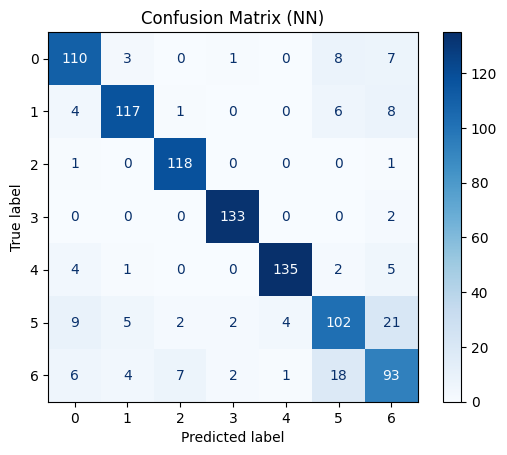

In [94]:
y_pred = classification.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
nn_accuracy = round(accuracy_score(y_test, y_pred), 2)

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix (NN)")
plt.show()

In [95]:
ae_nn_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
ae_nn_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
ae_nn_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
ae_nn_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for Autoencoder Neural Network classifier: {ae_nn_accuracy}')
metrics_df.loc['AutoEncoder NN Classifier'] = [ae_nn_accuracy, ae_nn_precision, ae_nn_recall, ae_nn_f1]

Accuracy score for Autoencoder Neural Network classifier: 85.68%


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       129
           1       0.87      0.90      0.88       136
           2       0.94      0.98      0.96       120
           3       0.96      0.99      0.97       135
           4       0.97      0.92      0.94       147
           5       0.76      0.70      0.73       145
           6       0.72      0.71      0.71       131

    accuracy                           0.86       943
   macro avg       0.86      0.87      0.86       943
weighted avg       0.86      0.86      0.86       943



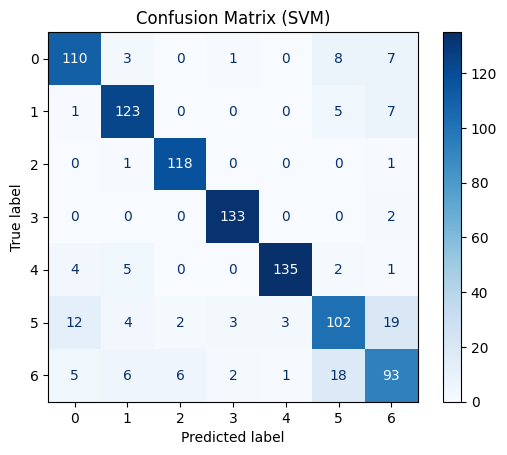

In [96]:
svm_classifier = SVC(kernel = 'rbf', random_state = 42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', refit = True, verbose = 1)
grid.fit(latent_features, y_train)
y_pred = grid.predict(latent_features_test)

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix (SVM)")
plt.show()

In [97]:
ae_svm_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
ae_svm_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
ae_svm_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
ae_svm_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for Autoencoder SVM classifier: {ae_svm_accuracy}')
metrics_df.loc['AutoEncoder SVM classifier'] = [ae_svm_accuracy, ae_svm_precision, ae_svm_recall, ae_svm_f1]

Accuracy score for Autoencoder SVM classifier: 86.32%


In [98]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%
Gnb,76.88%,75.74%,76.88%,74.97%
SVM,85.58%,85.34%,85.73%,85.47%
Hyp. Tuning SVM,87.17%,86.85%,87.32%,87.02%
FF Neural Network,92.26%,92.26%,92.27%,92.18%
SVM AutoEncoder dim. reduction,78.37%,78.39%,78.66%,78.44%
AutoEncoder NN Classifier,85.68%,85.71%,85.9%,85.76%
AutoEncoder SVM classifier,86.32%,86.21%,86.53%,86.33%


## TabNet

In [102]:
X_train = np.array(X_train)
X_test = np.array(X_test)

------------------------------------------------------------------------
Training for fold 1 ...
epoch 0  | loss: 1.8545  |  0:00:01s
epoch 1  | loss: 1.29117 |  0:00:03s
epoch 2  | loss: 1.02079 |  0:00:04s
epoch 3  | loss: 0.9197  |  0:00:06s
epoch 4  | loss: 0.90836 |  0:00:08s
epoch 5  | loss: 0.80307 |  0:00:09s
epoch 6  | loss: 0.77365 |  0:00:10s
epoch 7  | loss: 0.75844 |  0:00:10s
epoch 8  | loss: 0.72856 |  0:00:11s
epoch 9  | loss: 0.71681 |  0:00:12s
epoch 10 | loss: 0.65214 |  0:00:12s
epoch 11 | loss: 0.64154 |  0:00:14s
epoch 12 | loss: 0.66277 |  0:00:15s
epoch 13 | loss: 0.64692 |  0:00:16s
epoch 14 | loss: 0.60518 |  0:00:16s
epoch 15 | loss: 0.58342 |  0:00:17s
epoch 16 | loss: 0.58454 |  0:00:18s
epoch 17 | loss: 0.59591 |  0:00:20s
epoch 18 | loss: 0.54426 |  0:00:21s
epoch 19 | loss: 0.55575 |  0:00:21s
epoch 20 | loss: 0.521   |  0:00:22s
epoch 21 | loss: 0.50402 |  0:00:23s
epoch 22 | loss: 0.50471 |  0:00:24s
epoch 23 | loss: 0.49469 |  0:00:24s
epoch 24 | loss

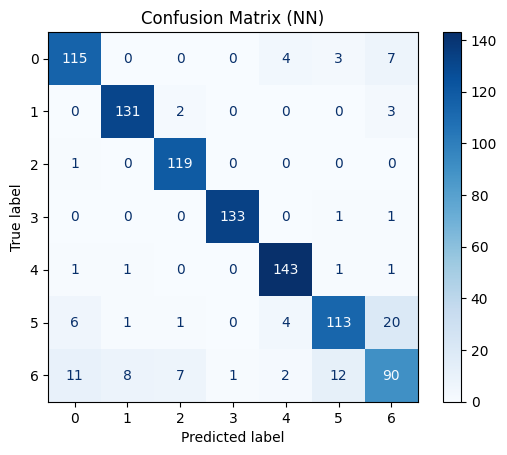

In [108]:
num_plits = 5
kfold = KFold(n_splits = num_plits)

acc_per_fold = []
loss_per_fold = []
best_score = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model = TabNetClassifier()
    model.fit(
        np.array(X.iloc[train]), np.array(y.iloc[train]),
        max_epochs = 150,
        patience = 10,
        batch_size = 128,
    )
    accuracy = accuracy_score(model.predict(np.array(X_train.iloc[test])), np.array(y_train.iloc[test]))
    print(f'Accuracy score for fold {fold_no}: {round(accuracy*100, 2)}%')
    acc_per_fold.append(round(accuracy, 2) * 100)

    if accuracy > best_score:
        best_model = model
        best_score = accuracy
    
    if fold_no == num_plits:
        y_pred = best_model.predict(np.array(X_test))
    
        nn_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
        nn_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        nn_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        nn_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for NN classifier: {nn_accuracy}')
        metrics_df.loc['TabNet'] = [nn_accuracy, nn_precision, nn_recall, nn_f1]
    
        # Classification report and confusion matrix
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
    
        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        disp.plot(cmap = plt.cm.Blues)
        plt.title("Confusion Matrix (NN)")
        plt.show()
    fold_no = fold_no + 1

In [109]:
acc_per_fold

[83.0, 81.0, 83.0, 82.0, 82.0]

In [110]:
metrics_df

,ACCURACY,PRECISION,RECALL,F1
Raw Gnb,43.47%,46.92%,49.7%,37.46%
Gnb,76.88%,75.74%,76.88%,74.97%
SVM,85.58%,85.34%,85.73%,85.47%
Hyp. Tuning SVM,87.17%,86.85%,87.32%,87.02%
FF Neural Network,92.26%,92.26%,92.27%,92.18%
SVM AutoEncoder dim. reduction,78.37%,78.39%,78.66%,78.44%
AutoEncoder NN Classifier,85.68%,85.71%,85.9%,85.76%
AutoEncoder SVM classifier,86.32%,86.21%,86.53%,86.33%
TabNet,89.5%,89.2%,89.58%,89.31%


# TO-DO
- hyp tuning NN, 
- cross-validation in all the models
- TabNet
- FTTransformer

# IDEAS
- feat eng polynomial features, 
- Apply transformations like log, sqrt, or Box-Cox for skewed features, 
- use pre-trained models or transfer learning if applicable.
